In [2]:
import requests
from bs4 import BeautifulSoup
import urllib.request
from urllib.request import urlopen
from urllib.request import urlparse
import time
from urllib.error import HTTPError
import re
import numpy as np
import timeago, datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tabulate import tabulate
import random

In [259]:
URL = 'https://www.indeed.com.mx/trabajo?q=energia&l=Mexico&sort=date'
page = requests.get(URL)
soup = BeautifulSoup(urllib.request.urlopen(URL).read(), 'html.parser')

In [260]:
soup = BeautifulSoup(page.text, 'html.parser')

In [818]:
print(soup.prettify())

<!DOCTYPE html>
<html dir="ltr" lang="es">
 <head>
  <meta content="text/html;charset=utf-8" http-equiv="content-type"/>
  <script src="//d3fw5vlhllyvee.cloudfront.net/s/ed8f221/es_MX.js" type="text/javascript">
  </script>
  <link href="//d3fw5vlhllyvee.cloudfront.net/s/b512638/jobsearch_all.css" rel="stylesheet" type="text/css"/>
  <link href="http://www.indeed.com.mx/rss?q=energia&amp;l=Mexico&amp;sort=date" rel="alternate" title="Bolsa trabajo: Energia - México, empleo" type="application/rss+xml"/>
  <link href="/m/jobs?q=energia&amp;l=Mexico&amp;sort=date" media="only screen and (max-width: 640px)" rel="alternate"/>
  <link href="/m/jobs?q=energia&amp;l=Mexico&amp;sort=date" media="handheld" rel="alternate"/>
  <script type="text/javascript">
   if (typeof window['closureReadyCallbacks'] == 'undefined') {
window['closureReadyCallbacks'] = [];
}

function call_when_jsall_loaded(cb) {
if (window['closureReady']) {
cb();
} else {
window['closureReadyCallbacks'].push(cb);
}
}
  </scri

In [819]:
def extract_job_title_from_result(soup): 
    jobs = []
    for div in soup.find_all(name="div", attrs={"class":"row"}):
        for a in div.find_all(name="a", attrs={"data-tn-element":"jobTitle"}):
            jobs.append(a["title"])
    return(jobs)


extract_job_title_from_result(soup)

['Logistas',
 'Asociado de planta',
 'Administrador de Planta',
 'SUPERVISOR DE OBRA ELECTRICA',
 'GERENTE DE SISTEMAS',
 'Cuidador de Animales',
 'PROGRAMADOR SCADA',
 'Supervisor a detalle comercializacion de refresco y agua',
 'supervisor de ventas a detalle miscelaneas',
 'ENCARGADO DE SEGURIDAD Y MEDIO AMBIENTE',
 'Ing. Eléctrico o Practicante',
 'Head of Business Development',
 'Ingeniero Eléctrico',
 'Supply Gas Manager',
 'Promotor Digital']

In [820]:
def extract_company_from_result(soup):
    companies = []
    for div in soup.find_all(name="div", attrs={"class":"row"}):
        company = div.find_all(name="span", attrs={"class":"company"})
        if len(company) > 0:
            for b in company:
                companies.append(b.text.strip())
        else:
            sec_try = div.find_all(name="span", attrs={"class":"result-link-source"})
            for span in sec_try:
                companies.append(span.text.strip())
    return(companies)

extract_company_from_result(soup)


['MÉDICOS SIN FRONTERAS EN MÉXICO A.C',
 'Covia Corp',
 'Covia Corp',
 'Invex Grupo Financiero',
 'Invex Grupo Financiero',
 'Scantibodies',
 'Invex Grupo Financiero',
 'GEPP / E-pura / Pepsi',
 'GEPP / E-pura / Pepsi',
 'CORPORACION MITSUBA DE MEXICO SA DE CV',
 'Grupo Energos',
 'Wurzel Group',
 'Grupo Energos',
 'Wurzel Group',
 'Natgas']

In [821]:
def extract_location_from_result(soup): 
    locations = []
    spans = soup.findAll('span', attrs={'class': 'location'})
    for span in spans:
        locations.append(span.text)
    return(locations)

extract_location_from_result(soup)

['Coatzacoalcos, Ver.',
 'Tetla de la Solidaridad, Tlax.',
 'Ahuazotepec, Pue.',
 'Miguel Hidalgo, CDMX',
 'Miguel Hidalgo, CDMX',
 'Tijuana, B.C.',
 'Miguel Hidalgo, CDMX',
 'Ixtapaluca, Méx.',
 'Venustiano Carranza, CDMX',
 'Apodaca, N. L.',
 'Monterrey, N. L.',
 'Cuauhtémoc, CDMX',
 'Monterrey, N. L.',
 'Cuauhtémoc, CDMX',
 'Monterrey, N. L.']

In [822]:
def extract_salary_from_result(soup): 
    salaries = []
    for div in soup.find_all(name='div', attrs={'class':'row'}):
        try:
            salaries.append(div.find('salarySnippet').text)
        except:
            try:
                div_two = div.find(name='div', attrs={'class':'salaryText'})
                div_three = div_two.find('div')
                salaries.append(div_three.text.strip())
            except:
                salaries.append('Nothing_found')
    return(salaries)

extract_salary_from_result(soup)

['Nothing_found',
 'Nothing_found',
 'Nothing_found',
 'Nothing_found',
 'Nothing_found',
 'Nothing_found',
 'Nothing_found',
 'Nothing_found',
 'Nothing_found',
 'Nothing_found',
 'Nothing_found',
 'Nothing_found',
 'Nothing_found',
 'Nothing_found',
 'Nothing_found']

In [823]:
def extract_summary_from_result(soup): 
    summaries = []
    spans = soup.findAll('span', attrs={'class': 'summary'})
    for span in spans:
        summaries.append(span.text.strip())
    return(summaries)

extract_summary_from_result(soup)

[]

# Scraping Indeed -

### Testing scraper

In [824]:
# INDEED.COM.MX

def parse(url):
    html = requests.get(url)
    soup = BeautifulSoup(html.content, 'html.parser', from_encoding="utf-8")
    df = pd.DataFrame(columns=["Title","Location","Company","Salary", "Synopsis","Link","Date"])
    for each in soup.find_all(class_= "result" ):
        try: 
            title = each.find(class_='jobtitle').text.replace('\n', '')
        except:
            title = 'None'
        try:
            location = each.find('span', {'class':"location" }).text.replace('\n', '')
        except:
            location = 'None'
        try:
            link = each.find(class_='jobtitle').get('href')
        except:
            link = 'None'            
        try: 
            company = each.find(class_='company').text.replace('\n', '')
        except:
            company = 'None'
        try:
            salary = each.find('span', {'class':'no-wrap'}).text
        except:
            salary = 'None'
        try:
            date = each.find('span', {'class':'date '}).text
        except:
            date = 'None'
        try:
            synopsis = each.find('div', {'class':"summary"}).text.replace('\n', '')
        except:
            synopsis = 'None'
        df = df.append({'Title':title, 'Location':location, 'Company':company, 'Salary':salary, 'Synopsis':synopsis, "Link":link, "Date":date}, ignore_index=True)
    return df

In [825]:
df_indeed = parse(URL)

In [826]:
df_indeed[['Municipality', 'State']] = df_indeed['Location'].str.split(pat = ",", n = 1, expand=True)
df_indeed['Link'] = 'https://www.indeed.com.mx' + df_indeed['Link'].astype(str)


In [827]:
df_indeed

Title  \
0                                                   Logistas   
1                                         Asociado de planta   
2                                    Administrador de Planta   
3                               SUPERVISOR DE OBRA ELECTRICA   
4                                        GERENTE DE SISTEMAS   
5                                       Cuidador de Animales   
6                                          PROGRAMADOR SCADA   
7   Supervisor a detalle comercializacion de refresco y agua   
8                 supervisor de ventas a detalle miscelaneas   
9                    ENCARGADO DE SEGURIDAD Y MEDIO AMBIENTE   
10                              Ing. Eléctrico o Practicante   
11                              Head of Business Development   
12                                       Ingeniero Eléctrico   
13                                        Supply Gas Manager   
14                                          Promotor Digital   

                          Location                                 Company  \
0              Coatzacoalcos, Ver.     MÉDICOS SIN FRONTERAS EN MÉXICO A.C   
1   Tetla de la Solidaridad, Tlax.                              Covia Corp   
2                Ahuazotepec, Pue.                              Covia Corp   
3             Miguel Hidalgo, CDMX                  Invex Grupo Financiero   
4             Miguel Hidalgo, CDMX                  Invex Grupo Financiero   
5                    Tijuana, B.C.                            Scantibodies   
6             Miguel Hidalgo, CDMX                  Invex Grupo Financiero   
7                 Ixtapaluca, Méx.                   GEPP / E-pura / Pepsi   
8        Venustiano Carranza, CDMX                   GEPP / E-pura / Pepsi   
9                   Apodaca, N. L.  CORPORACION MITSUBA DE MEXICO SA DE CV   
10                Monterrey, N. L.                           Grupo Energos   
11                Cuauhtémoc, CDMX                            Wurzel Group   
12                Monterrey, N. L.                           Grupo Energos   
13                Cuauhtémoc, CDMX                            Wurzel Group   
14                Monterrey, N. L.                                  Natgas   

                            Salary  \
0   \n\n$14,000 - $14,258 al mes\n   
1                             None   
2                             None   
3                             None   
4                             None   
5                             None   
6                             None   
7   \n\n$15,000 - $20,000 al mes\n   
8   \n\n$15,000 - $20,000 al mes\n   
9                             None   
10    \n\n$6,000 - $8,000 al mes\n   
11                            None   
12  \n\n$12,000 - $16,000 al mes\n   
13                            None   
14    \n\n$4,000 - $6,500 al mes\n   

                                                                                                                                                           Synopsis  \
0                 Realiza el mantenimiento de los equipos de logística de cadena de frío, la energía, la informática y las comunicaciones por radio, en particular:   
1   Covia es el proveedor líder de minerales y soluciones de material para los mercados de energía e industrial.Nuestra habilidad para entregar nuestros productos…   
2   Covia es el proveedor líder de minerales y soluciones de material para los mercados de energía e industrial.Nuestra habilidad para entregar nuestros productos…   
3            EN NUESTRA DIVISIÓN DE INFRAESTRUCTURA Y ENERGÍA , NOS ENCONTRAMOS BUSCANDO:Escolaridad: Ingeniero Electricista, Eléctrico, Mecánico Eléctrico o afín.   
4     EN NUESTRA DIVISIÓN DE INFRAESTRUCTURA Y ENERGÍA, BUSCAMOS:Ingeniero en Sistemas, Telemática o afines.Nivel de Inglés Intermedio/ Avanzado ( Conversacional).   
5                                        Descripción y detalle de las actividades.El cuidador de animales de Bioterio es responsable de las siguientes actividades:   
6  

In [828]:
ind_descriptions = []
for link in df_indeed.iterrows():
    url = link[1]['Link']
    x = urllib.request.urlopen(url)
    desc = x.read()
    soup = BeautifulSoup(desc,"lxml")
    description = soup.find('div', {"id":"jobDescriptionText"}).get_text().replace('\n', '')
    ind_descriptions.append(description)

In [829]:
df_indeed['Description'] = ind_descriptions

In [830]:
df_indeed

Title  \
0                                                   Logistas   
1                                         Asociado de planta   
2                                    Administrador de Planta   
3                               SUPERVISOR DE OBRA ELECTRICA   
4                                        GERENTE DE SISTEMAS   
5                                       Cuidador de Animales   
6                                          PROGRAMADOR SCADA   
7   Supervisor a detalle comercializacion de refresco y agua   
8                 supervisor de ventas a detalle miscelaneas   
9                    ENCARGADO DE SEGURIDAD Y MEDIO AMBIENTE   
10                              Ing. Eléctrico o Practicante   
11                              Head of Business Development   
12                                       Ingeniero Eléctrico   
13                                        Supply Gas Manager   
14                                          Promotor Digital   

                          Location                                 Company  \
0              Coatzacoalcos, Ver.     MÉDICOS SIN FRONTERAS EN MÉXICO A.C   
1   Tetla de la Solidaridad, Tlax.                              Covia Corp   
2                Ahuazotepec, Pue.                              Covia Corp   
3             Miguel Hidalgo, CDMX                  Invex Grupo Financiero   
4             Miguel Hidalgo, CDMX                  Invex Grupo Financiero   
5                    Tijuana, B.C.                            Scantibodies   
6             Miguel Hidalgo, CDMX                  Invex Grupo Financiero   
7                 Ixtapaluca, Méx.                   GEPP / E-pura / Pepsi   
8        Venustiano Carranza, CDMX                   GEPP / E-pura / Pepsi   
9                   Apodaca, N. L.  CORPORACION MITSUBA DE MEXICO SA DE CV   
10                Monterrey, N. L.                           Grupo Energos   
11                Cuauhtémoc, CDMX                            Wurzel Group   
12                Monterrey, N. L.                           Grupo Energos   
13                Cuauhtémoc, CDMX                            Wurzel Group   
14                Monterrey, N. L.                                  Natgas   

                            Salary  \
0   \n\n$14,000 - $14,258 al mes\n   
1                             None   
2                             None   
3                             None   
4                             None   
5                             None   
6                             None   
7   \n\n$15,000 - $20,000 al mes\n   
8   \n\n$15,000 - $20,000 al mes\n   
9                             None   
10    \n\n$6,000 - $8,000 al mes\n   
11                            None   
12  \n\n$12,000 - $16,000 al mes\n   
13                            None   
14    \n\n$4,000 - $6,500 al mes\n   

                                                                                                                                                           Synopsis  \
0                 Realiza el mantenimiento de los equipos de logística de cadena de frío, la energía, la informática y las comunicaciones por radio, en particular:   
1   Covia es el proveedor líder de minerales y soluciones de material para los mercados de energía e industrial.Nuestra habilidad para entregar nuestros productos…   
2   Covia es el proveedor líder de minerales y soluciones de material para los mercados de energía e industrial.Nuestra habilidad para entregar nuestros productos…   
3            EN NUESTRA DIVISIÓN DE INFRAESTRUCTURA Y ENERGÍA , NOS ENCONTRAMOS BUSCANDO:Escolaridad: Ingeniero Electricista, Eléctrico, Mecánico Eléctrico o afín.   
4     EN NUESTRA DIVISIÓN DE INFRAESTRUCTURA Y ENERGÍA, BUSCAMOS:Ingeniero en Sistemas, Telemática o afines.Nivel de Inglés Intermedio/ Avanzado ( Conversacional).   
5                                        Descripción y detalle de las actividades.El cuidador de animales de Bioterio es responsable de las siguientes actividades:   
6  

### Complete scrape - looping through every single page with jobs

In [302]:
url_template = 'https://www.indeed.com.mx/trabajo?q=energia&l=Mexico&sort=date&start={}'
max_results = 1000
i = 0
results = []
df_indeed = pd.DataFrame(columns=["Title","Location","Company","Salary", "Synopsis", "Link", "Date"])
for start in range(0, max_results, 1):
    # get results from request above
    url = url_template.format(start)
    # append to full set
    html = requests.get(url)
    soup = BeautifulSoup(html.content, 'html.parser', from_encoding = "utf-8")
    for each in soup.find_all(class_="result"):
        try: 
            title = each.find(class_='jobtitle').text.replace('\n', '')
        except:
            title = 'None'
        try:
            location = each.find('span', {'class':"location" }).text.replace('\n', '')
        except:
            location = 'None'
        try: 
            company = each.find(class_='company').text.replace('\n', '')
        except:
            company = 'None'
        try:
            date = each.find('span', {'class':'date'}).text
        except:
            date = 'None'
        try:
            link = each.find(class_='jobtitle').get('href')
        except:
            link = 'None'
        try:
            salary = each.find('span', {'class':'no-wrap'}).text
        except:
            salary = 'None'
        try:
            synopsis = each.find('div', {'class':"summary"}).text.replace('\n', '')
        except:
            synopsis = 'None'
        df_indeed = df_indeed.append({'Title':title, 'Location':location, 'Company':company, 'Salary':salary, 'Synopsis':synopsis, 'Link':link, 'Date':date}, ignore_index=True)
        i += 1
        if i % 1000 == 0: 
            print("you have" + str(i) + 'results. ' + str(df_indeed.dropna().drop_duplicates().shape[0]) + " of these aren't rubbish.")

you have1000results. 121 of these aren't rubbish.
you have2000results. 235 of these aren't rubbish.
you have3000results. 326 of these aren't rubbish.
you have4000results. 430 of these aren't rubbish.
you have5000results. 535 of these aren't rubbish.
you have6000results. 556 of these aren't rubbish.
you have7000results. 556 of these aren't rubbish.
you have8000results. 556 of these aren't rubbish.
you have9000results. 556 of these aren't rubbish.
you have10000results. 556 of these aren't rubbish.
you have11000results. 556 of these aren't rubbish.
you have12000results. 571 of these aren't rubbish.
you have13000results. 571 of these aren't rubbish.
you have14000results. 571 of these aren't rubbish.


In [303]:
df_indeed = df_indeed.drop_duplicates()

In [304]:
df_indeed[df_indeed.Salary.str.contains("mes") == True]

Title  \
0                      Asistente de medio ambiente 14001   
2                          Analista de Inventarios (SAP)   
3                                      Técnico eléctrico   
4                                  Jefe de mantenimiento   
10     Ejecutiva de Importaciones – Agencia Aduanal /...   
...                                                  ...   
5118                       Electromecánico de ingeniería   
5125                                    Agente de Ventas   
5269                         Asesor de Ventas de Seguros   
11359                                   Agente de Ventas   
11368                        Asesor de Ventas de Seguros   

                       Location                                Company  \
0                   Silao, Gto.                      tritech autoparts   
2                   Lerma, Méx.  Energía 5 Mas 1 Comercio S.A. de C.V.   
3                 Metepec, Méx.                               SAYCENER   
4               Monclova, Coah.                     DANNYS RESTAURANTE   
10            Guadalajara, Jal.                             Grupo Bolt   
...                         ...                                    ...   
5118   Cuautitlán Izcalli, Méx.                             BIC México   
5125              Tláhuac, CDMX               Grupo Financiero Inbursa   
5269           Ciudad de México                          Seguros Atlas   
11359             Tláhuac, CDMX               Grupo Financiero Inbursa   
11368          Ciudad de México                          Seguros Atlas   

                               Salary  \
0      \n\n$13,000 - $14,000 al mes\n   
2        \n\n$7,500 - $8,000 al mes\n   
3        \n\n$7,000 - $8,000 al mes\n   
4        \n\n$5,600 - $7,600 al mes\n   
10     \n\n$14,000 - $18,000 al mes\n   
...                               ...   
5118             \n\n$11,000 al mes\n   
5125              \n\n$6,000 al mes\n   
5269             \n\n$25,000 al mes\n   
11359             \n\n$6,000 al mes\n   
11368            \n\n$25,000 al mes\n   

                                                Synopsis  \
0      Realiza balances de materia y energía.Gestiona...   
2      Importante empresa manufacturera de productos ...   
3      Llenado de formatos electrónicos y Generación ...   
4      El papel requiere eficiencia, mucha energía y ...   
10     Si eres una persona positiva, con mucha energí...   
...                                                  ...   
5118   Ejecuta acciones de ahorro de energía y reducc...   
5125   Esta vacante viene de la bolsa de empleo Talen...   
5269   Asesor de Ventas de Seguros.Oliva&Asociados bu...   
11359  Esta vacante viene de la bolsa de empleo Talen...   
11368  Asesor de Ventas de Seguros Oliva&Asociados bu...   

                                                    Link  Date  
0      /company/tritech-autoparts/jobs/Asistente-medi...  None  
2      /company/ENERGIA-5+1/jobs/Analista-inventarios...  None  
3      /company/SAYCENER/jobs/T%C3%A9cnico-el%C3%A9ct...  None  
4      /company/DANNYS-RESTAURANTE/jobs/Jefe-mantenim...  None  
10     /company/Grupo-Bolt---Agencia-Aduanal/jobs/Eje...  None  
...                                                  ...   ...  
5118   /rc/clk?jk=182f6ef37233820c&fccid=bfe4c7383e87...  None  
5125   /rc/clk?jk=562dd827b172d621&fccid=07470b37a9c2...  None  
5269   /rc/clk?jk=b932abff0afbb40e&fccid=a81cee74aa00...  None  
11359  /rc/clk?jk=562dd827b172d621&fccid=07470b37a9c2...  None  
11368  /rc/clk?jk=b932abff0afbb40e&fccid=a81cee74aa00...  None  

[217 rows x 7 columns]

In [834]:
df_indeed[df_indeed.Salary.str.contains("hora") == True]

Title      Location     Company              Salary  \
3026  Líder Técnico JavaScript  Mérida, Yuc.  Pulpomatic  \n\n$16 por hora\n   
3926          Technical Leader  Mérida, Yuc.  Pulpomatic  \n\n$16 por hora\n   

                                                                                                                                                               Synopsis  \
3026  Si eres un apasionado de las ventas y te gustaría seguir desarrollándote en una empresa que está en crecimiento, en donde puedes aportar y traer toda tu energía…   
3926  Si eres un apasionado de las ventas y te gustaría seguir desarrollándote en una empresa que está en crecimiento, en donde puedes aportar y traer toda tu energía…   

                                                          Link  \
3026  /rc/clk?jk=a90c416b5b3d8923&fccid=942c4ec626ccb63b&vjs=3   
3926  /rc/clk?jk=f01747c99cb71d70&fccid=942c4ec626ccb63b&vjs=3   

                     Date  
3026  Hace más de 30 días  
3926  Hace más de 30 días

In [835]:
df_indeed[df_indeed.Salary.str.contains("año") == True]

Title                            Location  \
4371  Analista de Datos (inglés avanzado)  Colonia Lomas de Chapultepec, CDMX   
4519             Gerente de Mercadotecnia                    Monterrey, N. L.   

               Company                          Salary  \
4371  DocPlanner Group            \n\n$25,000 al año\n   
4519     PageExecutive  \n\n$47,000 - $70,000 al año\n   

                                                                                                                                                         Synopsis  \
4371  Doctoralia es la plataforma de reserva de citas médicas online donde pacientes de todo el mundo encuentran el doctor que mejor se adapta a sus necesidades.   
4519     Empresa de soluciones en energía solar.Empresa de soluciones en energía solar busca un Gerente de Mercadotecnia.Desarrollo y gestión de estrategias BTL.   

                                                          Link  \
4371  /rc/clk?jk=436d9c836998c35f&fccid=12d899d8d1864c15&vjs=3   
4519  /rc/clk?jk=8412ecfbacfd127e&fccid=1bbd46589c8eeece&vjs=3   

                     Date  
4371  Hace más de 30 días  
4519  Hace más de 30 días

In [836]:
print(df_indeed.shape)

(627, 7)


In [837]:
df_indeed[['Municipality', 'State']] = df_indeed['Location'].str.split(pat = ",", n = 1, expand=True)
df_indeed['Link'] = 'https://www.indeed.com.mx' + df_indeed['Link'].astype(str)


### Scraping full job description using specific job page link from dframe column LInk

In [839]:
ind_descriptions = []
for link in df_indeed.iterrows():
    url = link[1]['Link']
    html = requests.get(url)
    soup = BeautifulSoup(html.content, 'html.parser', from_encoding="utf-8")
#    x = urllib.request.urlopen(url)
#    desc = x.read()
    try:
        description = soup.find('div', {"id":"jobDescriptionText"}).get_text().replace('\n', '')
    except:
        description = 'None'
    ind_descriptions.append(description)

In [840]:
# view results
df_indeed['Description'] = ind_descriptions

In [841]:
df_indeed

Title  \
0                                                      Logistas   
1                                            Asociado de planta   
2                                       Administrador de Planta   
3                                  SUPERVISOR DE OBRA ELECTRICA   
4                                           GERENTE DE SISTEMAS   
5                                             PROGRAMADOR SCADA   
6                                          Cuidador de Animales   
7      Supervisor a detalle comercializacion de refresco y agua   
8                       ENCARGADO DE SEGURIDAD Y MEDIO AMBIENTE   
9                                  Ing. Eléctrico o Practicante   
10                                          Ingeniero Eléctrico   
11                                 Head of Business Development   
12                   supervisor de ventas a detalle miscelaneas   
13                                           Supply Gas Manager   
14                                             Promotor Digital   
15                          Energy BI & Data Science Specialist   
16                      Gerente de estructuración de soluciones   
17                                              Gerente de Obra   
18                                         Ventas Técnicas CCTV   
19                          Coordinador De Cobranza Call Center   
20                                        Analista Contable Sr.   
21                 EPIDEMIOLOGO para DIRECTOR GESTION SANITARIA   
22                                         Ingeniero de Soporte   
23                                         Representante Médico   
24                                  Auxiliares de mantenimiento   
25                            EJECUTIVO DE VENTAS CORPORTATIVAS   
26                         Becario de Finanzas y Data Analytics   
27                                           ASESOR PATRIMONIAL   
28                                                    Topógrafo   
29                        Asesor de Cotizaciones (inside Sales)   
...                                                         ...   
4973                               Superintendente de Soldadura   
4974                                        Automation Engineer   
4975                                           Comprador Senior   
4976                                      Mesero de Restaurante   
4977                                          Asesor Financiero   
4978                                   Auxiliar de Nominas-Imss   
4979                                Personal Técnico en Soporte   
5115  Profesor de tiempo completo para la Escuela de Ingeniería   
5116                              Superintendente de Produccion   
5117           REPRESENTANTE DE VENTAS DE ALEACIONES ESPECIALES   
5118                                      Auxiliar de Servicios   
5119                                Asesor de Ventas de Seguros   
5120                                        Ingeniero eléctrico   
5121                                 Asistente de Mantenimiento   
5242                                Asesor de Ventas de Seguros   
5830                            Customer Service Representative   
5831                               Superintendente de Soldadura   
5832                                        Automation Engineer   
5833                                           Comprador Senior   
5834                                      Mesero de Restaurante   
5835                                          Asesor Financiero   
5836                                   Auxiliar de Nominas-Imss   
5837                                Personal Técnico en Soporte   
5838  Profesor de tiempo completo para la Escuela de Ingeniería   
5839                              Superintendente de Produccion   
5840           REPRESENTANTE DE VENTAS DE ALEACIONES ESPECIALES   
5841                                      Auxiliar de Servicios   
5842                                Asesor de Ventas de Seguros   
5843                                  

In [842]:
# write out to csv
df_indeed.to_excel(r'C:\Users\jparr\OneDrive - DAI\Mexico_FCO_Energy\df_indeed_jobs_06_16.xlsx')

## Scraping Bumeran.com.mx

In [642]:
# Bumeran
# URL = 'https://www.bumeran.com.mx/empleos-busqueda-energia.html?recientes=true'
html = urllib.request.Request(url='https://www.bumeran.com.mx/empleos-busqueda-energia.html?recientes=true', headers={'User-Agent':' Mozilla/5.0 (Windows NT 6.1; WOW64; rv:12.0) Gecko/20100101 Firefox/12.0'})
handler = urllib.request.urlopen(html)
soup = BeautifulSoup(handler, 'html.parser')
print(soup.prettify())

<!DOCTYPE html>
<html lang="en">
 <head>
  <meta charset="utf-8"/>
  <meta content="width=device-width,initial-scale=1" name="viewport"/>
  <link href="/candidate/favicon/favicon.ico" rel="shortcut icon"/>
  <link href="/candidate/favicon/apple-touch-icon.png" rel="apple-touch-icon" sizes="180x180"/>
  <link href="/candidate/favicon/favicon-32x32.png" rel="icon" sizes="32x32" type="image/png"/>
  <link href="/candidate/favicon/favicon-16x16.png" rel="icon" sizes="16x16" type="image/png"/>
  <link href="/candidate/favicon/site.webmanifest" rel="manifest"/>
  <link color="#3d47f5" href="/candidate/favicon/safari-pinned-tab.svg" rel="mask-icon"/>
  <meta content="#ffffff" name="msapplication-TileColor"/>
  <meta content="#ffffff" name="theme-color"/>
  <link href="/candidate/favicon/site.webmanifest.json" rel="manifest">
   <title>
   </title>
   <script type="text/javascript">
    function newRelicScript(t,e,n,r){window.NREUM||(NREUM={}),__nr_require=function(n,r,t){function o(e){if(!r[e

In [844]:
def parse(url):
    html = requests.get(url)
    soup = BeautifulSoup(html.content, 'html.parser', from_encoding="utf-8")
    df_bumeran = pd.DataFrame(columns=["Title","Location","Location_2","Company","Date","Salary", "Synopsis"])
    for each in soup.find_all('div', {'class':"list"}):
        try: 
            title = each.find('div', {'class':'aviso'}).text.replace('\n', '')
        except:
            title = 'None'
        try:
            location = each.find('span', {'class':"ubicacion_link" }).text.replace('\n', '')
        except:
            location = 'None'
        try:
            location_2 = each.find('span', {'class':"ubicacion_link.ellipsis" }).text.replace('\n', '')
        except:
            location_2 = 'None'
        try: 
            company = each.find(class_='empresa_nombre_link').text.replace('\n', '')
        except:
            company = 'None'
        try: 
            date = each.find(class_='fecha').text.replace('\n', '')
        except:
            date = 'None'
        try:
            synopsis = each.find('div', {'class':"descripcion"}).text.replace('\n', '')
        except:
            synopsis = 'None'
        df_bumeran = df_bumeran.append({'Title':title, 'Location':location, 'Location':location_2, 'Company':company, 'Date':date, 'Synopsis':synopsis}, ignore_index=True)
    return df_bumeran

In [845]:
# url = 'https://www.bumeran.com.mx/empleos-busqueda-energia.html?recientes=true'
# html = urlopen(url)
# soup = BeautifulSoup(html, 'lxml')
# title = soup.title 
# titleText = title.get_text()
# print(titleText)

In [846]:
print(soup.prettify())

<!DOCTYPE html>
<!--[if lt IE 7]> <html class="no-js ie6 oldie" lang="en-US"> <![endif]-->
<!--[if IE 7]>    <html class="no-js ie7 oldie" lang="en-US"> <![endif]-->
<!--[if IE 8]>    <html class="no-js ie8 oldie" lang="en-US"> <![endif]-->
<!--[if gt IE 8]><!-->
<html class="no-js" lang="en-US">
 <!--<![endif]-->
 <head>
  <title>
   Access denied | www.bumeran.com.mx used Cloudflare to restrict access
  </title>
  <meta charset="utf-8"/>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <meta content="IE=Edge,chrome=1" http-equiv="X-UA-Compatible"/>
  <meta content="noindex, nofollow" name="robots"/>
  <meta content="width=device-width,initial-scale=1" name="viewport"/>
  <link href="/cdn-cgi/styles/cf.errors.css" id="cf_styles-css" media="screen,projection" rel="stylesheet" type="text/css"/>
  <!--[if lt IE 9]><link rel="stylesheet" id='cf_styles-ie-css' href="/cdn-cgi/styles/cf.errors.ie.css" type="text/css" media="screen,projection" /><![endif]-->
  <style t

In [847]:
parse(URL)

Empty DataFrame
Columns: [Title, Location, Location_2, Company, Date, Salary, Synopsis]
Index: []

## Scraping Computrabajo.com.mx

### Testing scraper

In [305]:
## Computrabajo
URL = 'https://www.computrabajo.com.mx/trabajo-de-energia?q=energia'
page = requests.get(URL)
soup = BeautifulSoup(page.text, 'html.parser')
print(soup.prettify())



<!DOCTYPE html>
<html lang="es-MX" xmlns="http://www.w3.org/1999/xhtml">
 <head>
  <title>
   Trabajo de energia Julio 2020 | Bolsa de trabajo México
  </title>
  <meta content="" name="title"/>
  <meta content="18 Ofertas de trabajo de energia en México. Encuentra el empleo que se adapte a lo que buscas. Cada día hay nuevas ofertas. ¡No esperes más y postulate ahora!" name="description"/>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type" id="ctl02"/>
  <meta content="width=device-width, initial-scale=1.0, user-scalable=no" id="ctl03" name="viewport"/>
  <meta content="IE=edge" http-equiv="X-UA-Compatible" id="ctl04"/>
  <meta content="(+10,000,000)" name="android_downloads"/>
  <meta content="app-id=com.redarbor.computrabajo" name="google-play-app"/>
  <meta content="app-id=1093787284" name="apple-itunes-app"/>
  <meta content="2" name="meta_ctp"/>
  <link href="/c/img/favicon.ico" rel="shortcut icon" type="image/x-icon"/>
  <link href="https://www.computrabajo.com.

In [468]:
def parse(url):
    html = requests.get(url)
    soup = BeautifulSoup(html.content, 'html.parser', from_encoding="utf-8")
    df = pd.DataFrame(columns=["Title","Municipality","State","Company","Salary", "Synopsis", "Date", "Link"])
    for each in soup.find_all(name="div", attrs={"class":"bRS"}):
                try: 
                    title = each.find('a', class_="js-o-link").get("title").replace('\n', '').replace('Empleo de ', '')
                except:
                    title = 'None'
                try:
                    location = each.find('div', class_="w_100").contents[3].text.replace('\n', '').split(",", maxsplit=1)[1]
                except:
                    location = 'None'
                try:
                    location_2 = each.find('div', class_="w_100").contents[3].text.replace('\n', '').split(",", maxsplit=1)[0]
                except:
                    location_2 = 'None'
                try:
                    date = each.find('span', class_='dO')
                except:
                    date = 'None'
                try: 
                    link = 'http://www.computrabajo.com.mx' + each.find('a', class_="js-o-link").get("href").replace('\n', '')
                except:
                    link = 'None'
                try: 
                    company = each.find('a', class_="fc_blue").get("title").replace('\n', '').replace('Empleos en ', '')
                except:
                    company = 'None'
                try:
                    salary =  each.find('meta', itemprop="baseSalary").get("content").replace('\n', '')
                except:
                    salary = 'None'
                try:
                    synopsis = each.find("p").text.replace('\n', '')
                except:
                    synopsis = 'None'
                df = df.append({'Title':title, 'Municipality':location, 'State':location_2, 'Company':company, 'Salary':salary, 'Synopsis':synopsis, 'Date':date, 'Link':link}, ignore_index=True)
    return df

In [469]:
computrab_df = parse(URL)

In [3]:
computrab_df

NameError: name 'computrab_df' is not defined

In [472]:
computrab_df['State'][4]

'Aguascalientes'

In [473]:
ct_descriptions = []
for link in computrab_df.iterrows():
    url = link[1]['Link']
    html = requests.get(url)
    soup = BeautifulSoup(html.content, 'html.parser', from_encoding="utf-8")
#    x = urllib.request.urlopen(url)
#    desc = x.read()
    try:
        description = soup.find('ul', {"class":"p0 m0"}).get_text().replace('\n', '').replace('\r', '')
    except:
        description = 'None'
    ct_descriptions.append(description)

In [483]:
computrab_df['Description'] = ct_descriptions
computrab_df['Description'] = computrab_df['Description'].str.replace('Descripción', '')

In [485]:
computrab_df.head()

Title     Municipality  \
0  Empresa de energía busca personal para área de...        Chihuahua   
1  Vacante Bilingüe en empresa de Energía - Turno PM        Chihuahua   
2  Administrador Financiero   Sector (Energía Elé...       Cuauhtémoc   
3      Gerente Operativo Sector de Energía Eléctrica       Cuauhtémoc   
4                    Mantenimiento Energias Mecanico   Aguascalientes   

                 State       Company Salary  \
0            Chihuahua          None   None   
1            Chihuahua          None   None   
2  Ciudad de México DF    Evolucione   None   
3  Ciudad de México DF    Evolucione   None   
4       Aguascalientes  JATCO MEXICO   None   

                                            Synopsis                Date  \
0  Importante empresa de gas y energía busca pers...  [Hoy, 05:41 p. m.]   
1  Somos la empresa líder en energía eléctrica, a...  [Hoy, 05:40 p. m.]   
2  E V O L U C I O N E, expertos en Capital Human...  [Hoy, 11:05 a. m.]   
3  E V O L U C I O N E, expertos en Capital Human...  [Hoy, 10:04 a. m.]   
4  JATCO México busca tecnicos de mantenimeinto e...  [Hoy, 06:11 a. m.]   

                                                Link  \
0  http://www.computrabajo.com.mx/ofertas-de-trab...   
1  http://www.computrabajo.com.mx/ofertas-de-trab...   
2  http://www.computrabajo.com.mx/ofertas-de-trab...   
3  http://www.computrabajo.com.mx/ofertas-de-trab...   
4  http://www.computrabajo.com.mx/ofertas-de-trab...   

                                         Description  
0  Importante empresa de gas y energía busca pers...  
1  Somos la empresa líder en energía eléctrica, a...  
2   E V O L U C I O N E, expertos en Capital Huma...  
3   E V O L U C I O N E, expertos en Capital Huma...  
4  JATCO México busca tecnicos de mantenimeinto e...

In [486]:
computrab_df['Description'][0]

'Importante empresa de gas y energía busca personal para su área de atención a clientes    Requisitos indispensables: -Edad: 16 años en adelante-Escolaridad: Secundaria (contar con certificado)-Inglés conversacional 80% mínimo-Manejo de computadora-Disponibilidad por las TARDES-Vivir en Chihuahua, Chih. (Vacante presencial)   Ofrecemos:  -Excelente sueldo base + prestaciones superiores a la ley-Bonos por desempeño-Vales-Oportunidad de crecimiento en 90 días-Flexibilidad de horario (respetamos restricciones de escuela, guardería, transporte, etc.)  *Actividades: Servicio al cliente y soporte técnico de usuarios. Contamos con programa de entrenamiento pagado   Interesados favor de postularse por este medioNuestro proceso de contratación es inmediatoRequerimientosEducación mínima: Educación secundariaIdiomas: Inglés Disponibilidad de viajar: NoDisponibilidad de cambio de residencia: No '

In [521]:
ct_salaries = []
for link in computrab_df.iterrows():
    url = link[1]['Link']
    html = requests.get(url)
    soup = BeautifulSoup(html.content, 'html.parser', from_encoding="utf-8")
#    x = urllib.request.urlopen(url)
#    desc = x.read()
    try:
        salary = soup.find('section', {"class":"boxWhite"}).find('span', itemprop="baseSalary").find('meta', itemprop='value').get('content')
    except:
        salary = 'None'
    ct_salaries.append(salary)
computrab_df['Salary'] = ct_salaries

In [522]:
computrab_df['Salary'] = ct_salaries

In [524]:
computrab_df['Salary']

0      None
1      None
2     47000
3     47000
4      None
5     11000
6     15500
7      9000
8      4139
9      8000
10    35000
11    35000
12    40000
13     None
14    15000
15     None
16    10000
17    10000
Name: Salary, dtype: object

### Complete scrape on each page returning results

In [855]:
url_template = 'https://www.computrabajo.com.mx/trabajo-de-energia?p={}&by=publicationtime&q=energia/'
max_results = 100
i = 0
results = []
computrabajo_df_more = pd.DataFrame(columns=["Title","Municipality","State","Company","Salary", "Synopsis", "Link"])
for start in range(0, max_results, 1):
    # get results from request above
    url = url_template.format(start)
    # append to full set
    html = requests.get(url)
    soup = BeautifulSoup(html.content, 'html.parser', from_encoding = "utf-8")
    for each in soup.find_all(name="div", attrs={"class":"bRS"}):
                try: 
                    title = each.find('a', class_="js-o-link").get("title").replace('\n', '').replace('Empleo de ', '')
                except:
                    title = 'None'
                try:
                    location = each.find('div', class_="w_100").contents[3].text.replace('\n', '').split(",", maxsplit=1)[1]
                except:
                    location = 'None'
                try:
                    location_2 = each.find('div', class_="w_100").contents[3].text.replace('\n', '').split(",", maxsplit=1)[0]
                except:
                    location_2 = 'None'
                try:
                    date = each.find('span', class_='dO')
                except:
                    date = 'None'
                try: 
                    link = 'http://www.computrabajo.com.mx' + each.find('a', class_="js-o-link").get("href").replace('\n', '')
                except:
                    link = 'None'
                try: 
                    company = each.find('a', class_="fc_blue").get("title").replace('\n', '').replace('Empleos en ', '')
                except:
                    company = 'None'
                try:
                    salary =  each.find('meta', itemprop="baseSalary").get("content").replace('\n', '')
                except:
                    salary = 'None'
                try:
                    synopsis = each.find("p").text.replace('\n', '')
                except:
                    synopsis = 'None'
                computrabajo_df_more = computrabajo_df_more.append({'Title':title, 'Municipality':location, 'State':location_2, 'Company':company, 'Salary':salary, 'Synopsis':synopsis, 'Date':date, 'Link':link}, ignore_index=True)            
                i += 1
                if i % 1000 == 0: 
                    print("you have" + str(i) + 'results. ' + str(computrabajo_df_more.dropna().drop_duplicates().shape[0]) + " of these aren't rubbish.")

In [856]:
computrabajo_df_more = computrabajo_df_more.drop_duplicates()
print(computrabajo_df_more.shape)

(26, 8)


### Scrape full job descriptions on job page. 

In [857]:
ct_descriptions = []
for link in computrabajo_df_more.iterrows():
    url = link[1]['Link']
    x = urllib.request.urlopen(url)
    desc = x.read()
    soup = BeautifulSoup(desc,"lxml")
    description = soup.find('ul', {"class":"p0 m0"}).get_text().replace('\n', '').replace('\r', '')
    ct_descriptions.append(description)

In [858]:
computrabajo_df_more['Description'] = ct_descriptions

### Scrape job salary

In [521]:
ct_salaries = []
for link in computrab_df.iterrows():
    url = link[1]['Link']
    html = requests.get(url)
    soup = BeautifulSoup(html.content, 'html.parser', from_encoding="utf-8")
#    x = urllib.request.urlopen(url)
#    desc = x.read()
    try:
        salary = soup.find('section', {"class":"boxWhite"}).find('span', itemprop="baseSalary").find('meta', itemprop='value').get('content')
    except:
        salary = 'None'
    ct_salaries.append(salary)
computrabajo_df_more['Salary'] = ct_salaries

In [522]:
computrabajo_df_more['Salary'] = ct_salaries

In [524]:
computrabajo_df_more['Salary']

0      None
1      None
2     47000
3     47000
4      None
5     11000
6     15500
7      9000
8      4139
9      8000
10    35000
11    35000
12    40000
13     None
14    15000
15     None
16    10000
17    10000
Name: Salary, dtype: object

In [859]:
computrabajo_df_more

Title  \
0                                                          Especialista de producto - Imagenología y Energía   
1                                                                               Líder de proyecto - Energías   
2                                                         Supervisor Ambiental de Obra - Energías Renovables   
3                                                    Empresa de energía busca personal para área de atención   
4                                                          Vacante Bilingüe en empresa de Energía - Turno PM   
5                                                                            Mantenimiento Energias Mecanico   
6                                                                 Atención a cliente para empresa de energía   
7                                                       Biólogo/a de Impacto Ambiental - Energías Renovables   
8        Operador de grua y JCB  Conductor 4x4 y autobus - con licencia para proyecto de Energias Renovables   
9   1)Ingeniero electrónico o mecatrónico p/área comercial - 2) residentes ingeniería para área de servicio.   
10                                            Reconocida empresa de Energia esta Contratando - Ingles Nativo   
11                  Electricista, Soldadores, operadores - experiencia en Proyectos Energía solar Renovables   
12                                                                           Asesor Ventas - Con Experiencia   
13                                                             Gerente Operativo Sector de Energía Eléctrica   
14                                                     Administrador Financiero   Sector (Energía Eléctrica)   
15                                                                                       Jefe Administración   
16                                                                                 Tecnico - Energía Heolica   
17                                                   Supervisor Técnico de Operaciones - Energias Renovables   
18                                        Personal con inglés avanzado para empresa internacional de energía   
19                                                        Buscamos personal bilingue para empresa de energía   
40                                                               Becario  - Ingeniero en Energías Renovables   
41                                                 Vacante para empresa de energía inglés avanzado necesario   
42                                                                                          Contador General   
43                                                           Tecnico en Aire Acondicionado - Con experiencia   
44                                                                  Ingeniero Forestal - Energías Renovables   
45                                                           Ejecutivo de Ventas Corporativo - Energía Solar   

           Municipality                State  \
0   Naucalpan de Juárez     Estado de México   
1                Puebla               Puebla   
2            Cuauhtémoc  Ciudad de México DF   
3             Chihuahua            Chihuahua   
4             Chihuahua            Chihuahua   
5        Aguascalientes       Aguascalientes   
6           Guadalajara              Jalisco   
7                                              
8                Puebla               Puebla   
9             Querétaro            Querétaro   
10               Puebla               Puebla   
11               Puebla               Puebla   
12              Morelia            Michoacán   
13           Cuauhtémoc  Ciudad de México DF   
14           Cuauhtémoc  Ciudad de México DF   
15               Mérida              Yucatán   
16           El Espinal               Oaxaca   
17             Mexicali      Baja California   
18           Hermosillo               Sonora   
19           Hermosillo               Sonora   
40           Cuauhtémoc  Ciudad de México DF   
41           Hermosill

In [860]:
computrabajo_df_more

Title  \
0                                                          Especialista de producto - Imagenología y Energía   
1                                                                               Líder de proyecto - Energías   
2                                                         Supervisor Ambiental de Obra - Energías Renovables   
3                                                    Empresa de energía busca personal para área de atención   
4                                                          Vacante Bilingüe en empresa de Energía - Turno PM   
5                                                                            Mantenimiento Energias Mecanico   
6                                                                 Atención a cliente para empresa de energía   
7                                                       Biólogo/a de Impacto Ambiental - Energías Renovables   
8        Operador de grua y JCB  Conductor 4x4 y autobus - con licencia para proyecto de Energias Renovables   
9   1)Ingeniero electrónico o mecatrónico p/área comercial - 2) residentes ingeniería para área de servicio.   
10                                            Reconocida empresa de Energia esta Contratando - Ingles Nativo   
11                  Electricista, Soldadores, operadores - experiencia en Proyectos Energía solar Renovables   
12                                                                           Asesor Ventas - Con Experiencia   
13                                                             Gerente Operativo Sector de Energía Eléctrica   
14                                                     Administrador Financiero   Sector (Energía Eléctrica)   
15                                                                                       Jefe Administración   
16                                                                                 Tecnico - Energía Heolica   
17                                                   Supervisor Técnico de Operaciones - Energias Renovables   
18                                        Personal con inglés avanzado para empresa internacional de energía   
19                                                        Buscamos personal bilingue para empresa de energía   
40                                                               Becario  - Ingeniero en Energías Renovables   
41                                                 Vacante para empresa de energía inglés avanzado necesario   
42                                                                                          Contador General   
43                                                           Tecnico en Aire Acondicionado - Con experiencia   
44                                                                  Ingeniero Forestal - Energías Renovables   
45                                                           Ejecutivo de Ventas Corporativo - Energía Solar   

           Municipality                State  \
0   Naucalpan de Juárez     Estado de México   
1                Puebla               Puebla   
2            Cuauhtémoc  Ciudad de México DF   
3             Chihuahua            Chihuahua   
4             Chihuahua            Chihuahua   
5        Aguascalientes       Aguascalientes   
6           Guadalajara              Jalisco   
7                                              
8                Puebla               Puebla   
9             Querétaro            Querétaro   
10               Puebla               Puebla   
11               Puebla               Puebla   
12              Morelia            Michoacán   
13           Cuauhtémoc  Ciudad de México DF   
14           Cuauhtémoc  Ciudad de México DF   
15               Mérida              Yucatán   
16           El Espinal               Oaxaca   
17             Mexicali      Baja California   
18           Hermosillo               Sonora   
19           Hermosillo               Sonora   
40           Cuauhtémoc  Ciudad de México DF   
41           Hermosill

In [861]:
# write to csv
computrabajo_df_more.to_excel(r'C:\Users\jparr\OneDrive - DAI\Mexico_FCO_Energy\computrabajo_df_more_06_16.xlsx')

## Scraping OCCMundial.com.mx

### Testing scraper

In [27]:
## OCC
URL = 'http://www.occ.com.mx/empleos/de-energia/'
# page = requests.get(URL)
# soup = BeautifulSoup(page.content, 'html5lib')
# print(soup.prettify())

client = requests.get(URL, headers = headers)  # grabs the page
soup = BeautifulSoup(client.text, 'html.parser')  # using the default html parser
# tables = soup.find_all('table')  # gets all the tables
# print(tables[7])  # scoring progression table, the 8th's table
print(soup.prettify())

&gt;D�P�s_6}�l_N;J�A+�JJ�2�&lt;��[����m��֌���\yoE�{�=�9�	$k�!1��R����F�1f�7��.D`B� ���ϼmƊ��C�L@�e��L��2�)�j%�L
<b�v!~�]� �.�q����k�t����l���y�hgf�p_m�ie����i��g��ӹ<44n�hr����0;m}�3��g�y)ɨma�="" c�bz�5�����p���u�z5ц����]nw�="" rsמ]�y���g?3\yb="" ��5���ϡ�n^�="" ��c���"���v,6��m�&����vq��pb�`�\o�s�t# �="">
' ��Y9��R��2/eF[A)��E�ݽʙ�l͍l�u�T�m��LU٭YI�
~�ӛ7��6�a'�F�AK�Vq&gt;��b����:̻����ѫ��K�G�H��`Mr�
 h��K�w������6�hgC������j��[ -�����#P���ȑ_�Z�3���FkJ5�j�!�d�&gt;	1�֯unr�6��0�sȧ�������Q7�@̈́��MjRl�UY��e��rA/2�R��U�ݾ͋�W�ţ���z�kak�p���U�?���܆�e�G�� :����['
*k���E�ٍg�%�k�)���,�&lt;�~�p���������Ŕd�R���YaGb_s��
�\I���QʒB\�����*�8���?Y�lf�}�߷�}���{1�~C)m /�]�&amp;�,��W��u�&gt;D��!����v`�g���DEm��]Y�9b�/��q�VQz��]Y.����b��M׀��3��u&lt;��9.�����?�go{B$���Q�5�}�!ܝc�����i/��Cwz�~�f]�{�f1RX�zj0�i��K���eBL�+õP���f&amp;N��~.Rh�qL��~p�(dB"�Z��2t�?�?5�Z&lt;�����۫�n������Zh��*f}+xWSӇ�M�(���֪�[A㈪�+v[Q5u���&lt

In [26]:
client

In [155]:
def parse(url):
    html = urlopen(url)
    soup = BeautifulSoup(html.read(), 'html.parser')  # using the default html parser
    df = pd.DataFrame(columns=["Title","Municipality","State","Company","Salary", "Area", "Synopsis","Link","Date"])
    for each in soup.find_all('div', class_="c01561"):
        try: 
            title = each.find('a', class_='trk-job-ad')["aria-label"].replace('\n', '').replace('Vacante ', '')
        except:
            title = 'None'
        try:
            location = each.find('a', {'class':"c01583"}).text.replace(',', '')
        except:
            location = 'None'
        try:
            location_2 = each.find('a', {'class':"c01584"}).text.replace('\n', '')
        except:
            location_2 = 'None'
        try:
            link = each.find('a', class_='trk-job-ad').get('href')
        except:
            link = 'None'            
        try: 
            company = each.find('a', class_='c01581')["title"].replace('Buscar empleos en ', '')
        except:
            company = 'None'
        try:
            salary = each.find('span', {'class':'c0122'}).text
        except:
            salary = 'None'
        try:
            date = each.find('label', {'class':"c0122"}).text
        except:
            date = 'None'
        try:
            area = each.find('a', {'class':"c01598"}).text.replace('\n', '')
        except:
            area = 'None'
        try:
            synopsis = 'None'
        except:
            synopsis = 'None'
        df = df.append({'Title':title, 'Municipality':location, 'State':location_2, 'Company':company, 'Salary':salary, 'Area':area, 'Synopsis':synopsis, "Link":link, "Date":date}, ignore_index=True)
    return df

In [173]:
occmundial_df = parse(URL)
occmundial_df['Link'] = "http://www.occ.com.mx" + occmundial_df['Link']
occmundial_df = occmundial_df[occmundial_df.Title != 'None']


In [299]:
occmundial_df1 = parse(URL)

HTTPError: HTTP Error 403: Forbidden

In [295]:
occmundial_df1

Empty DataFrame
Columns: [Title, Municipality, State, Company, Salary, Area, Synopsis, Link, Date]
Index: []

In [300]:
occmundial_df.Link.head()

1    http://www.occ.com.mx/empleo/oferta/13012534-g...
2    http://www.occ.com.mx/empleo/oferta/13024288-t...
3    http://www.occ.com.mx/empleo/oferta/13059084-a...
4    http://www.occ.com.mx/empleo/oferta/13064604-i...
5    http://www.occ.com.mx/empleo/oferta/13064594-i...
Name: Link, dtype: object

In [301]:
occ_descriptions = []
# for link in occmundial_df.iterrows():
#    url = link[1]['Link']
url = "https://www.occ.com.mx/empleo/oferta/13067686-becario-de-agronomia-medio-tiempo-jalisco?ai=false&origin=unknown&page=1&rank=12&returnURL=%2Fempleos%2Fde-energ%C3%ADa%2F%2312&sessionid=f9e5d17e-e841-46f7-881c-fa230277ee74&showseo=true&type=0&userid=&utm_channel=serp&utm_origin=web&uuid=08f1c236-84a4-4b05-9d23-c2614a1bc183"
headerinfo = {'User Agent':"Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36",
           'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
           'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
           'Accept-Encoding': 'none',
           'Accept-Language': 'en-US,en;q=0.8',
           'Connection': 'keep-alive'}
html = requests.get(url)
# desc = req.read()
# webpage = BeautifulSoup(desc, 'html.parser')
print(html)
#   urllib.request.urlopen(url)
#   desc = x.read()
#   soup = BeautifulSoup(desc,"lxml")
#    soup = BeautifulSoup(urlopen(html).read(), 'html.parser')
#    x = urllib.request.urlopen(url)
#    desc = x.read()
#    try:
#        description = soup.find('div', {"id":"jobbody"}).get_text().replace('\n', '').replace('\r', '')
#    except:
#        description = 'None'
#    occ_descriptions.append(description)

<Response [403]>


In [288]:
class AppURLopener(urllib.request.FancyURLopener):
    version = "Mozilla/5.0"

opener = AppURLopener()
response = opener.open('https://www.occ.com.mx/empleo/oferta/13064109-analista-sistemas-computarizados-farmaceutica-validacion?ai=false&amp;origin=unknown&amp;page=1&amp;rank=47&amp;returnURL=%2Fempleos%2Fde-energia%2F%2347&amp;sessionid=e3ceba2b-acb9-4dd1-bda2-7357e72e4a3b&amp;showseo=true&amp;type=1&amp;userid=&amp;utm_channel=serp&amp;utm_origin=web&amp;uuid=897f0ac0-1ad7-4944-9914-af2b4372dbd2')
print(response)


C:\Users\jparr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: AppURLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  after removing the cwd from sys.path.


<addinfourl at 2721842108288 whose fp = <http.client.HTTPResponse object at 0x00000279BA6DCEB8>>


In [275]:
from urllib2 import Request

req = Request(url, headers = {"User-Agent": "Mozilla/5.0"})

And then replace the line below:
response = urlopen(url)
with:
response = urlopen(req)

C:\Users\jparr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: AppURLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  after removing the cwd from sys.path.


AttributeError: 'tuple' object has no attribute 'read'

### Complete scrape on each page returning results

In [856]:
computrabajo_df_more = computrabajo_df_more.drop_duplicates()
print(computrabajo_df_more.shape)

(26, 8)


### Scrape full job descriptions on job page. 

In [646]:
user_agent_list = [
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.1.1 Safari/605.1.15',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:77.0) Gecko/20100101 Firefox/77.0',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:77.0) Gecko/20100101 Firefox/77.0',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
]



random.choice(user_agent_list)

'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.1.1 Safari/605.1.15'

In [ ]:

for i in range(1,4):
    user_agent = random.choice(user_agent_list)
    headers = {'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'accept-encoding': 'gzip, deflate, sdch, br',
    'accept-language': 'en-GB,en-US;q=0.8,en;q=0.6',
#    'referer': 'https://www.glassdoor.com/',
    'upgrade-insecure-requests': '1',
    'user-agent': user_agent,
    'Cache-Control': 'no-cache',
    'Connection': 'keep-alive'
    }
    location_headers = {
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.01',
    'accept-encoding': 'gzip, deflate, sdch, br',
    'accept-language': 'en-GB,en-US;q=0.8,en;q=0.6',
#    'referer': 'https://www.glassdoor.com/',
    'upgrade-insecure-requests': '1',
    'user-agent': user_agent,
    'Cache-Control': 'no-cache',
    'Connection': 'keep-alive'
    }

In [17]:
headers

{'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
 'accept-encoding': 'gzip, deflate, sdch, br',
 'accept-language': 'en-GB,en-US;q=0.8,en;q=0.6',
 'upgrade-insecure-requests': '1',
 'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:77.0) Gecko/20100101 Firefox/77.0',
 'Cache-Control': 'no-cache',
 'Connection': 'keep-alive'}

## Scraping Glassdoor

### Testing scraper

In [178]:
## Glassdoor
URL = 'https://www.glassdoor.com.mx/Empleo/energia-empleos-SRCH_KE0,7.htm'
# page = requests.get(URL)
# soup = BeautifulSoup(page.content, 'html5lib')
# print(soup.prettify())

client = requests.get(URL, headers = headers)  # grabs the page
soup = BeautifulSoup(client.text, 'html.parser')  # using the default html parser
# tables = soup.find_all('table')  # gets all the tables
# print(tables[7])  # scoring progression table, the 8th's table
print(soup.prettify())


<!DOCTYPE html>
<!DOCTYPE html>
<html>
 <head>
  <title>
   Empleos de energia | Glassdoor.com.mx
  </title>
  <meta content="origin" name="referrer"/>
  <meta content="-y15wxQ3oP0LlzeU3xnbrjNJW4VhNguPiVGWarEjJk" name="globalsign-domain-verification">
   <meta content="width=device-width" name="viewport"/>
   <meta content="#0caa41" name="theme-color"/>
   <meta content="#0caa41" name="msapplication-navbutton-color"/>
   <meta content="yes" name="apple-mobile-web-app-capable">
    <meta content="#0caa41" name="apple-mobile-web-app-status-bar-style"/>
    <meta content="589698942" property="al:ios:app_store_id">
     <meta content="Glassdoor" property="al:ios:app_name">
      <meta content="At9LpmW/SGKoQafqVaHTfeX5N9lRrOEZw0dAoUrKiO21CAbclpg0c0XecEzX5QigJaDNvdHGhDU8tDKRRduS6AYAAABmeyJvcmlnaW4iOiJodHRwczovL2dsYXNzZG9vci5jb206NDQzIiwiZmVhdHVyZSI6Ikluc3RhbGxlZEFwcCIsImV4cGlyeSI6MTUxNDI1NjE5NCwiaXNTdWJkb21haW4iOnRydWV9" data-expires="2017-12-26" data-feature="getInstalledRelatedApps" http-e

In [282]:
def parse(url):
#    html = urlopen(url)
#    soup = BeautifulSoup(html.read(), 'html.parser')  # using the default html parser
    df = pd.DataFrame(columns=["Title","Municipality","State","Company","Salary", "Area", "Synopsis","Link","Date"])
    for each in soup.find_all('li', class_='jl'):
        try:
            location = each.get('data-job-loc')
        except:
            location = 'None'
        try:
            location_2 = 'None'
        except:
            location_2 = 'None'
        try:
            link = each.find_all('a', class_='jobInfoItem')[1].get('href')
        except:
            link = 'None'            
        try: 
            title = each.find_all('a', class_='jobInfoItem')[1].text.replace('\n', '')
        except:
            title = 'None'
        try: 
            company = each.find_all('a', class_='jobInfoItem')[0].text.replace('\n', '')
        except:
            company = 'None'
        try:
            salary = 'None'
        except:
            salary = 'None'
        try:
            date = each.find('div', class_="d-flex").findChildren()[2].getText()
        except:
            date = 'None'
        try:
            area = 'None'
        except:
            area = 'None'
        try:
            synopsis = 'None'
        except:
            synopsis = 'None'
        df = df.append({'Title':title, 'Location':location, 'Municipality':location_2, 'State':location_2, 'Company':company, 'Salary':salary, 'Area':area, 'Synopsis':synopsis, "Link":link, "Date":date}, ignore_index=True)
    return df

In [283]:
glassdoor_df = parse(URL)

In [284]:
glassdoor_df

Title Municipality State  \
0   Administrador Financiero Sector (Energía Eléct...         None  None   
1    Gerente Operativo Para Compañía de Energía Solar         None  None   
2                            ASISTENTE ADMINISTRATIVA         None  None   
3                                 ejecutivo de ventas         None  None   
4       Ejecutivo de ventas telefónicas / Medio Turno         None  None   
5              EJECUTIVO DE VENTAS DE EQUIPOS SOLARES         None  None   
6   AYUDANTE GENERAL EN INSTALACION DE PANELES SOL...         None  None   
7   ESPECIALISTA EN RESPONSABILIDAD SOCIAL para DI...         None  None   
8                         VENDEDOR DE PANELES SOLARES         None  None   
9                                    Ayudante Tecnico         None  None   
10                      Tecnico en aire acondicionado         None  None   
11                   VENDEDOR, DE ENERGIAS RENOVABLES         None  None   
12             Técnico instalador energías renovables         None  None   
13          AUXILIAR DE TÉCNICO EN AIRE ACONDICIONADO         None  None   
14    Contador bilingüe para empresa de energía solar         None  None   
15      EJECUTIVO DE CUENTAS, PROYECTOS FOTOVOLTAICOS         None  None   
16  EJECUTIVO DE CUENTAS, VENTAS MAYOREO Y DISTRIB...         None  None   
17                                   ayudante general         None  None   
18                                 promotor de ventas         None  None   
19                        Ing. en Energías Renovables         None  None   
20                     Ingeniero en energía renovable         None  None   
21                          jefe de planta de energia         None  None   
22                  Especialista en Energía Eléctrica         None  None   
23     Ingeniero de servicio - Imagenología y Energía         None  None   
24                   Ingeniero en energías renovables         None  None   
25           ING. ELÉCTRICO EN CALIDAD DE LA ENERGÍA.         None  None   
26                Vendedor(a) tienda de energia solar         None  None   
27  Operador de campo – central generadora de energía         None  None   
28  Trabaja desde Chihuahua para Dallas Texas - 2 ...         None  None   
29  EXPERTO EN ASPEL (SAE, BANCOS, NOI) E IMPLEMEN...         None  None   

                                              Company Salary  Area Synopsis  \
0                                          Evolucione   None  None     None   
1                                          Evolucione   None  None     None   
2                     ENERGÍA COMPARTIDA SAPI DE C.V.   None  None     None   
3            Tecnoligente Energia Renovable SAS de CV   None  None     None   
4                ZENER ENERGÍA RENOVABLE S.A .DE C.V.   None  None     None   
5                                EVOLUO ENERGIA SOLAR   None  None     None   
6                                EVOLUO ENERGIA SOLAR   None  None     None   
7               Energía y Ecología Integral,IFEI S.C.   None  None     None   
8                ZENER ENERGÍA RENOVABLE S.A .DE C.V.   None  None     None   
9                                    ENERLUMY ENERGIA   None  None     None   
10            Control de Aire y Energía, S.A. de C.V.   None  None     None   
11                                            Bumeran   None  None     None   
12                                             copers   None  None     None   
13  PROYECTOS HVAC CON ENFOQUE EN OPTIMIZACION DE ...   None  None     None   
14                                            Bumeran   None  None     None   
15                                      aries energía   None  None     None   
16                                      aries energía   None  None     None   
17  Enerlumy Energia, Construccion y Consultoria S...   None  None     None   
18           Tecnoligente Energia Renovable SAS de CV   None  None     None   
19                                  Climas del Puerto   None  None     None   
20                 CONSTRUCCIONE

In [182]:
glassdoor_df.Title[0]

[<a class="jobInfoItem jobTitle jobLink" href="https://www.glassdoor.com.mx/partner/jobListing.htm?pos=101&amp;ao=437149&amp;s=58&amp;guid=00000173372ece5790c9bced3781c4e4&amp;src=GD_JOB_AD&amp;t=SR&amp;extid=1&amp;exst=E&amp;ist=L&amp;ast=EL&amp;slr=true&amp;cs=1_649addfe&amp;cb=1594358681257&amp;jobListingId=3576422953" rel="nofollow" target="_blank"><div class="jobInfoItem jobEmpolyerName">Evolucione</div></a>,
 <div class="jobInfoItem jobEmpolyerName">Evolucione</div>,
 <div class="saveJobWrap"><span class="save-job-button-3576422953 nowrap" data-test="save-job"><style data-emotion-css="9th5vf">.css-9th5vf{color:#1861bf;}</style><span class="SVGInline css-9th5vf"><svg class="SVGInline-svg css-9th5vf-svg" height="24" style="width: 20px;height: 20px;" viewbox="0 0 24 24" width="24" xmlns="http://www.w3.org/2000/svg"><path d="M12 5.11l.66-.65a5.56 5.56 0 017.71.19 5.63 5.63 0 010 7.92L12 21l-8.37-8.43a5.63 5.63 0 010-7.92 5.56 5.56 0 017.71-.19zm7.66 6.75a4.6 4.6 0 00-6.49-6.51L12 6.5

In [285]:
gd_descriptions = []

for link in glassdoor_df.iterrows():
    url = link[1]['Link']
    html = requests.get(url, headers = headers)
    soup = BeautifulSoup(html.content, 'html.parser', from_encoding="utf-8")
#    x = urllib.request.urlopen(url)
#    desc = x.read()
    try:
        gd_description = soup.find('div', {"class":"desc"}).get_text().replace('\n', '')
    except:
        gd_description = 'None'
    gd_descriptions.append(gd_description)

In [286]:
glassdoor_df['Description'] = gd_descriptions

In [287]:
glassdoor_df

Title Municipality State  \
0   Administrador Financiero Sector (Energía Eléct...         None  None   
1    Gerente Operativo Para Compañía de Energía Solar         None  None   
2                            ASISTENTE ADMINISTRATIVA         None  None   
3                                 ejecutivo de ventas         None  None   
4       Ejecutivo de ventas telefónicas / Medio Turno         None  None   
5              EJECUTIVO DE VENTAS DE EQUIPOS SOLARES         None  None   
6   AYUDANTE GENERAL EN INSTALACION DE PANELES SOL...         None  None   
7   ESPECIALISTA EN RESPONSABILIDAD SOCIAL para DI...         None  None   
8                         VENDEDOR DE PANELES SOLARES         None  None   
9                                    Ayudante Tecnico         None  None   
10                      Tecnico en aire acondicionado         None  None   
11                   VENDEDOR, DE ENERGIAS RENOVABLES         None  None   
12             Técnico instalador energías renovables         None  None   
13          AUXILIAR DE TÉCNICO EN AIRE ACONDICIONADO         None  None   
14    Contador bilingüe para empresa de energía solar         None  None   
15      EJECUTIVO DE CUENTAS, PROYECTOS FOTOVOLTAICOS         None  None   
16  EJECUTIVO DE CUENTAS, VENTAS MAYOREO Y DISTRIB...         None  None   
17                                   ayudante general         None  None   
18                                 promotor de ventas         None  None   
19                        Ing. en Energías Renovables         None  None   
20                     Ingeniero en energía renovable         None  None   
21                          jefe de planta de energia         None  None   
22                  Especialista en Energía Eléctrica         None  None   
23     Ingeniero de servicio - Imagenología y Energía         None  None   
24                   Ingeniero en energías renovables         None  None   
25           ING. ELÉCTRICO EN CALIDAD DE LA ENERGÍA.         None  None   
26                Vendedor(a) tienda de energia solar         None  None   
27  Operador de campo – central generadora de energía         None  None   
28  Trabaja desde Chihuahua para Dallas Texas - 2 ...         None  None   
29  EXPERTO EN ASPEL (SAE, BANCOS, NOI) E IMPLEMEN...         None  None   

                                              Company Salary  Area Synopsis  \
0                                          Evolucione   None  None     None   
1                                          Evolucione   None  None     None   
2                     ENERGÍA COMPARTIDA SAPI DE C.V.   None  None     None   
3            Tecnoligente Energia Renovable SAS de CV   None  None     None   
4                ZENER ENERGÍA RENOVABLE S.A .DE C.V.   None  None     None   
5                                EVOLUO ENERGIA SOLAR   None  None     None   
6                                EVOLUO ENERGIA SOLAR   None  None     None   
7               Energía y Ecología Integral,IFEI S.C.   None  None     None   
8                ZENER ENERGÍA RENOVABLE S.A .DE C.V.   None  None     None   
9                                    ENERLUMY ENERGIA   None  None     None   
10            Control de Aire y Energía, S.A. de C.V.   None  None     None   
11                                            Bumeran   None  None     None   
12                                             copers   None  None     None   
13  PROYECTOS HVAC CON ENFOQUE EN OPTIMIZACION DE ...   None  None     None   
14                                            Bumeran   None  None     None   
15                                      aries energía   None  None     None   
16                                      aries energía   None  None     None   
17  Enerlumy Energia, Construccion y Consultoria S...   None  None     None   
18           Tecnoligente Energia Renovable SAS de CV   None  None     None   
19                                  Climas del Puerto   None  None     None   
20                 CONSTRUCCIONE

### Empleos Petroleros

In [631]:
## Empleos Petroleros
URL = 'https://www.empleospetroleros.com/search-results-jobs/?searchId=1594766178.48&action=search&page=2&view=list'
# page = requests.get(URL)
# soup = BeautifulSoup(page.content, 'html5lib')
# print(soup.prettify())

client = requests.get(URL, headers = headers)  # grabs the page
soup = BeautifulSoup(client.text, 'html.parser')
# tables = soup.find_all('table')  # gets all the tables
# print(tables[7])  # scoring progression table, the 8th's table
print(soup.prettify())


<!DOCTYPE HTML>
<html lang="en-US" xml:lang="en-US" xmlns="http://www.w3.org/1999/xhtml">
 <head>
  <meta content="" name="keywords"/>
  <meta content="" name="description"/>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <meta content="193270877377117" property="fb:page_id"/>
  <meta content="http://empleospetrolerosdotorg.files.wordpress.com/2011/08/monoep_65fb.png" property="og:image"/>
  <meta content="width = 480" name="viewport"/>
  <meta content="width=device-width, initial-scale=1, maximum-scale=1" name="viewport"/>
  <title>
   EmpleosPetroleros: Search Results
  </title>
  <link href="https://www.empleospetroleros.com/templates/_system/main/images/css/form.css" rel="stylesheet" type="text/css"/>
  <link href="https://www.empleospetroleros.com/templates/EmpleosPetroleros2/main/images/skeleton/base.css" rel="stylesheet" type="text/css"/>
  <link href="https://www.empleospetroleros.com/templates/EmpleosPetroleros2/main/images/skeleton/skeleton.css" rel=

In [634]:
# def parse(url):
#    html = urlopen(url)
#    soup = BeautifulSoup(html.read(), 'html.parser')  # using the default html parser
#    df = pd.DataFrame(columns=["Title","Municipality","State","Company","Salary", "Area", "Synopsis","Link","Date"])
table = soup.find_all('table')[0]
empleospetroleros_df = pd.read_html(str(table))
table

<table cellspacing="0" class="minh6" width="95%">
<thead>
<tr>
<td width="50%">
<a href="?searchId=1594766178.48&amp;action=search&amp;sorting_field=Title&amp;sorting_order=ASC&amp;page=2">Título</a>
</td>
<td width="15%">
<a href="?searchId=1594766178.48&amp;action=search&amp;sorting_field=City&amp;sorting_order=ASC&amp;page=2">Ciudad</a>
</td>
<td width="10%">
<a href="?searchId=1594766178.48&amp;action=search&amp;sorting_field=activation_date&amp;sorting_order=ASC&amp;page=2">Publicada</a>
<i class="icon-caret-down"></i> </td>
<td align="center" width="25%">
<a href="?searchId=1594766178.48&amp;action=search&amp;sorting_field=CompanyName&amp;sorting_order=ASC&amp;page=2">Empresa</a>
</td>
</tr>
</thead>
<tbody>
<!-- Job Info Start -->
<!--tr class="evenrow">
			<td colspan="6">
                                <table-->
<tr>
<td width="50%">
<a name="listing_223687"></a>
<a "="" href="https://www.empleospetroleros.com/display-job/223687/currículo.html?searchId=1594766178.48&amp;page=

In [332]:
display(empleospetroleros_df)

[                                                Título            Ciudad  \
 0                  Ingeniero Ver detalles de la oferta      Villahermosa   
 1       ingenieria petrolera Ver detalles de la oferta           Tampico   
 2    Ingeniero Químico Petrolero Ver detalles de la...       Chicoloapan   
 3    INGENIERO QUÍMICO PETROLERO Ver detalles de la...      Huimanguillo   
 4         Lic. Mercadotecnia Ver detalles de la oferta  Estado de Mexico   
 ..                                                 ...               ...   
 96   Licenciada en mercadotecnia Ver detalles de la...       Guadalajara   
 97         Ingeniero Quimico Ver detalles de la oferta            Mexico   
 98   Pasante Ingeniería Química Petrolera Ver detal...  Ciudad de México   
 99   Especialista en Mantenimiento de Equipos Dinám...          Frontera   
 100                                                NaN               NaN   
 
       Publicada  Empresa  Unnamed: 4  Unnamed: 5  
 0    09.07.2020      

AttributeError: 'list' object has no attribute 'dtype'

In [303]:
print(tabulate(empleospetroleros_df[0], headers='keys', tablefmt='psql'))
 

NameError: name 'tabulate' is not defined

### Complete scrape on each page returning results

### Scrape full job descriptions on job page. 

## Buscojobs.com.mx

### Testing scraper

In [525]:
## Buscojobs
URL = 'https://www.buscojobs.mx/search/energia_'
page = requests.get(URL)
soup = BeautifulSoup(page.text, 'html.parser')
print(soup.prettify())


<!DOCTYPE html>
<html lang="es">
 <head>
  <meta charset="utf-8"/>
  <meta content="IE=edge" http-equiv="X-UA-Compatible"/>
  <meta content="width=device-width, initial-scale=1, user-scalable=no" name="viewport"/>
  <meta content="index,follow" name="robots">
   <meta content="index,follow" name="googlebot">
    <meta content="Bolsa de Trabajo en México, Ofertas de Empleo en México | BuscoJobs" name="title">
     <meta content="trabajo en México, buscojobs México, empleo México, bolsa de trabajo México, Atención al Cliente en México, Auxiliar Administrativo en México,  Comercial - Ventas en México, busco jobs México, ofertas laborales México, ofertas de empleos, buscar trabajo" name="keywords"/>
     <meta content="Encuentra miles de ofertas de trabajo en Buscojobs México: Atención al Cliente en México, Auxiliar Administrativo en México,  Comercial - Ventas en México, y muchos más" name="description"/>
     <!-- Open Graph implementation (http://ogp.me/) -->
     <meta content="Buscojo

In [526]:
def parse(url):
    html = requests.get(url)
    soup = BeautifulSoup(html.content, 'html.parser', from_encoding="utf-8")
    buscojobs_df = pd.DataFrame(columns=["Title","Company","Salary", "Date", "Synopsis", "Link"])
    for each in soup.find_all(name = "div", attrs={"class":"col-lg-9"}):
                try: 
                    title = each.find("h3").get_text().replace('\n', '')
                except:
                    title = 'None'
                try:
                    company = each.find("span").get_text().replace('\n', '').replace('\t', '')
                except:
                    company = 'None'
                try:
                    date =  each.find('span', {"class":'pull-right'}).text.replace('\n', '')
                except:
                    date = 'None'
                try:
                    salary =  each.find('span', {"class":'pull-right'}).text.replace('\n', '')
                except:
                    salary = 'None'
                try:
                    link = each.find("a").get('href')
                except:
                    link = "None"
                try:
                    synopsis = each.find_all("span")[2].get_text().replace('\n', '').replace('\t', '')
                except:
                    synopsis = 'None'
                buscojobs_df = buscojobs_df.append({'Title':title, 'Company':company, 'Salary':salary, 'Date':date, 'Synopsis':synopsis, 'Link':link}, ignore_index=True)
    return(buscojobs_df) 
                

In [527]:
buscojobs_df = parse(URL)

In [528]:
buscojobs_df[['Company', 'Location']] = buscojobs_df['Company'].str.split(pat = "-", n = 1, expand=True)
buscojobs_df['Link'] = 'http:' + buscojobs_df['Link'].astype(str)

In [529]:
buscojobs_df

Title  \
0                               CONSULTOR FINANCIERO    
1                               CONSULTOR FINANCIERO    
2                          Human Resources Supervisor   
3                       Tecnico De Operaciones Senior   
4      Coordinador De Contabilidad (Contador General)   
5                            Procurement Data Analyst   
6                         Embedded Software Developer   
7                                  Promotor De Ventas   
8                            Chófer Suc Coatzacoalcos   
9                  Ayudante General Suc Coatzacoalcos   
10                  Jefe De Almacen Suc Coatzacoalcos   
11                        Global Sales Representative   
12                                  Sr Java Developer   
13                                             Server   
14  Vendedor Industrial Empresa De Energia Y Autom...   
15  Integraded Management System Plant Lngeniero D...   

                                              Company                 Salary  \
0   Grupo Nacional Provincial Dirección de Agencia...  Publicado hace 3 días   
1   Grupo Nacional Provincial Dirección de Agencia...  Publicado hace 3 días   
2        Aim Soldadura De Mexico S.A. De C.V.          Publicado hace un día   
3                           Johnson & Johnson          Publicado hace un día   
4                                     Bumeran          Publicado hace un día   
5                              Ppg Industries          Publicado hace un día   
6                             Smartrecruiters          Publicado hace un día   
7                                 Empleonuevo          Publicado hace un día   
8                              Computrabajomx          Publicado hace un día   
9                              Computrabajomx          Publicado hace un día   
10                             Computrabajomx          Publicado hace un día   
11             Servicios Comerciales Amazon M          Publicado hace un día   
12                                 Consultnet          Publicado hace un día   
13                Marriott International, Inc          Publicado hace un día   
14                             Computrabajomx          Publicado hace un día   
15                             Computrabajomx          Publicado hace un día   

                     Date                                           Synopsis  \
0   Publicado hace 3 días  Promotoría de Grupo Nacional Provincial, empre...   
1   Publicado hace 3 días  Promotoría de Grupo Nacional Provincial, empre...   
2   Publicado hace un día  Human Resources SupervisorSummaryUnder the aut...   
3   Publicado hace un día  "Johnson & Johnson companies are equal opportu...   
4   Publicado hace un día  Empresa en el sector de Energía. Es una empres...   
5   Publicado hace un día  As a Procurement Data Analyst, you will be res...   
6   Publicado hace un día  Company Description Bosch was founded in Stutt...   
7   Publicado hace un día  Empresa de la Construcción está en búsqueda de...   
8   Publicado hace un día  Buscamos aumentar nuestro equipo de trabajo co...   
9   Publicado hace un día  Buscamos aumentar nuestro equipo de trabajo co...   
10  Publicado hace un día  Buscamos aumentar nuestro equipo de trabajo co...   
11  Publicado hace un día  BA/BS degree5+ years of experience in roles su...   
12  Publicado hace un día  Sr Java DeveloperGuadalajara, Mexico12 Month C...   
13  Publicado hace un día  Posting Date Jun 30, 2020Job Number 20037882Jo...   
14  Publicado hace un día  Empresa de Energia y Automatizacion Busca Vend...   
15  Publicado hace un día  Principal Object. Assure the integrated manage...   

                                                 Link  \
0   http://www.buscojobs.mx/consultor-financiero-I...   
1   http://www.buscojobs.mx/consultor-financiero-I...   
2   http://www.buscojobs.mx/human-resources-superv...   
3   http://www.buscojobs.mx/tecnico-de-operaciones...   
4   http://www.buscojobs.mx/coordinador-de-contabi...   
5   http://www

In [867]:
descriptions = []
companies = []
locations = []
areas = []

for link in buscojobs_df.iterrows():
    url = link[1]['Link']
    html = requests.get(url)
    soup = BeautifulSoup(html.content, 'html.parser', from_encoding="utf-8")
#    x = urllib.request.urlopen(url)
#    desc = x.read()
    description = soup.find('div', {"class":"col-md-12 descripcion-texto"}).get_text().replace('\n', '')
    descriptions.append(description)
    try:
        company = soup.find_all('h2')[0]
    except:
        company = 'None'
    companies.append(company)
    try:
        location = soup.find_all('h2')[1]
    except:
        location = "None"
    locations.append(location)
    try:
        area = soup.find_all('h2')[2]
    except:
        area = 'None'
    areas.append(area)
    

In [868]:
buscojobs_df['Description'] = descriptions
buscojobs_df['Company'] = companies
buscojobs_df['Location'] = locations
buscojobs_df['Area'] = areas


In [869]:
buscojobs_df['Location'] = buscojobs_df['Location'].astype(str).apply(lambda x: re.sub('<[^<]+?>', '', x))
buscojobs_df['Company'] = buscojobs_df['Company'].astype(str).apply(lambda x: re.sub('<[^<]+?>', '', x))
buscojobs_df['Area'] = buscojobs_df['Area'].astype(str).apply(lambda x: re.sub('<[^<]+?>', '', x))

In [870]:
buscojobs_df[['Location', 'Location 2']] = buscojobs_df['Location'].str.split(pat = ",", expand=True)

In [871]:
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_colwidth = 5000
buscojobs_df


Title  \
0                                                   Promotor Digital   
1                                                   Promotor Digital   
2                              Ingenieroa En Sitio Cerro Del Mirador   
3              Ejecutivoa De Ventas Sucursal Citibanamex Calera, Zac   
4                                                Ejecutivo Comercial   
5                                                Gerente De Sistemas   
6                                                Facilities Engineer   
7                    Técnico De Mantenimiento De Maquinaria Y Equipo   
8                                      Analista De Cuentas Por Pagar   
9                 Ingeniero Biomédico Titulado Ingeniero De Servicio   
10                                                  Promotor Digital   
11                Ingeniero Biomédico Titulado Ingeniero De Servicio   
12                                     Promotor Digital Medio Tiempo   
13                                                   Consultor Murex   
14           Técnico Especialista De Seguridad Electrónica Queretaro   
15  Representante O Ejecutivo De Ventas Monterrey Empresa Docplanner   

                   Company                 Salary                   Date  \
0           Computrabajomx  Publicado hace un día  Publicado hace un día   
1           Computrabajomx  Publicado hace un día  Publicado hace un día   
2           Computrabajomx  Publicado hace un día  Publicado hace un día   
3           Computrabajomx  Publicado hace un día  Publicado hace un día   
4          Meraki Asesores  Publicado hace un día  Publicado hace un día   
5   Invex Grupo Financiero  Publicado hace un día  Publicado hace un día   
6                    Intel  Publicado hace un día  Publicado hace un día   
7              Empleonuevo  Publicado hace un día  Publicado hace un día   
8              Empleonuevo  Publicado hace un día  Publicado hace un día   
9           Computrabajomx  Publicado hace un día  Publicado hace un día   
10          Computrabajomx  Publicado hace un día  Publicado hace un día   
11          Computrabajomx  Publicado hace un día  Publicado hace un día   
12          Computrabajomx  Publicado hace un día  Publicado hace un día   
13          Computrabajomx  Publicado hace un día  Publicado hace un día   
14          Computrabajomx  Publicado hace un día  Publicado hace un día   
15          Computrabajomx  Publicado hace un día  Publicado hace un día   

                                                                                                                                                    Synopsis  \
0        Te gustaría ser Promotor Digital de una empresa en expansión Únete a nosotrosRequisitosMayor a 18 añosInterés y gusto por el área de servicio al...   
1        Te gustaría ser Promotor Digital de una empresa en expansión Únete a nosotrosRequisitosMayor a 18 añosInterés y gusto por el área de servicio al...   
2             Se parte del equipo TV Azteca, en atracción de talento te estamos buscando.Intégrate como INGENIERO EN SITIO RECIÉN EGRESADO EN LA ESTACIÓN...   
3                CITIBANAMEX SOLICITA PERSONAL COMO EJECUTIVOEJECUTIVA DE VENTAS EN SUCURSAL CALERA, ZACFunciones Negociación, mantenimiento, retención y...   
4   Requisitos:- Disponibilidad inmediata - Alto nivel de energía - Gusto por el área comercial - Buenas relaciones interpersonalesActividades a realizar...   
5    EN NUESTRA DIVISIÓN DE INFRAESTRUCTURA Y ENERGÍA, BUSCAMOS:GERENTE DE SISTEMASREQUERIMIENTOS DEL PUESTO:· Ingeniero en Sistemas, Telemática o afines...   
6       Facilities Engineer Job Description Join Intel-and build a better tomorrow! Intel is in the midst of an exciting transformation, with a vision to...   
7      • Diagnostica, analiza y repara las fallas surgidas durante los procesos• Mantiene las instalaciones y servicios dentro de la planta.• Ejecuta las...   
8     Mantiene una estrecha comunicación con proveedores en cuanto a coordinación de pagos y revisión de 

### Complete scrape of all results returned

In [872]:
url_template = 'https://www.buscojobs.mx/search/energia_/{}'
max_results = 2000
i = 0
results = []
buscojobs_df = pd.DataFrame(columns=["Title","Company","Salary", "Date", "Synopsis", "Link"])
for start in range(0, max_results, 1):
    # get results from request above
    url = url_template.format(start)
    # append to full set
    html = requests.get(url)
    soup = BeautifulSoup(html.content, 'html.parser', from_encoding = "utf-8")
    for each in soup.find_all(name = "div", attrs={"class":"col-lg-9"}):
                try: 
                    title = each.find("h3").get_text().replace('\n', '')
                except:
                    title = 'None'
                try:
                    company = each.find("span").get_text().replace('\n', '').replace('\t', '')
                except:
                    company = 'None'
                try:
                    date =  each.find('span', {"class":'pull-right'}).text.replace('\n', '')
                except:
                    date = 'None'
                try:
                    salary =  'None'
                except:
                    salary = 'None'
                try:
                    synopsis = each.find_all("span")[2].get_text().replace('\n', '').replace('\t', '')
                except:
                    synopsis = 'None'
                try:
                    link = each.find("a").get('href')
                except:
                    link = "None"
                buscojobs_df = buscojobs_df.append({'Title':title, 'Company':company, 'Salary':salary, 'Date':date, 'Synopsis':synopsis, 'Link':link}, ignore_index=True)
                i += 1
                if i % 1000 == 0: 
                    print("you have" + str(i) + 'results. ' + str(buscojobs_df.dropna().drop_duplicates().shape[0]) + " of these aren't rubbish.")

you have1000results. 919 of these aren't rubbish.
you have2000results. 1919 of these aren't rubbish.


In [873]:
buscojobs_df[['Company', 'Location']] = buscojobs_df['Company'].str.split(pat = "-", n = 1, expand=True)
buscojobs_df[['Location', 'Location 2']] = buscojobs_df['Location'].str.split(pat = ",", n = 1, expand=True)
buscojobs_df['Link'] = 'http:' + buscojobs_df['Link'].astype(str)

In [874]:
buscojobs_df

Title  \
0                                                 Cuidador De Animales   
1                                                 Cuidador De Animales   
2                                                  Front End Developer   
3                                           Ejecutivo De Cre?Dito Pyme   
4                                          Finance Manager, Latam Team   
5                                               Regional Sales Manager   
6                                Asesor De Cotizaciones (Inside Sales)   
7                                          Product & Process Developer   
8     Representante O Ejecutivo De Ventas Monterrey Empresa Docplanner   
9                                      Mantenimiento Energias Mecanico   
10                                   Atención Al Cliente Exp Logistica   
11                Promotor Digital Mercadotecnia Ventasdifusión De App   
12                                                 Gerente De Estación   
13                                                 Gerente De Sistemas   
14                                                 Facilities Engineer   
15                                                 Ejecutivo Comercial   
16                                                Cuidador De Animales   
17                                                Cuidador De Animales   
18                                                 Front End Developer   
19                                          Ejecutivo De Cre?Dito Pyme   
20                                         Finance Manager, Latam Team   
21                                              Regional Sales Manager   
22                               Asesor De Cotizaciones (Inside Sales)   
23                                         Product & Process Developer   
24    Representante O Ejecutivo De Ventas Monterrey Empresa Docplanner   
25                                     Mantenimiento Energias Mecanico   
26                                   Atención Al Cliente Exp Logistica   
27                Promotor Digital Mercadotecnia Ventasdifusión De App   
28                                                 Gerente De Estación   
29                                                 Gerente De Sistemas   
...                                                                ...   
2404                                                              None   
2405                                                              None   
2406                                                              None   
2407                                                              None   
2408                                                              None   
2409                                                              None   
2410                                                              None   
2411                                                              None   
2412                                                              None   
2413                                                              None   
2414                                                              None   
2415                                                              None   
2416                                                              None   
2417                                                              None   
2418                                                              None   
2419                                                              None   
2420                                                              None   
2421                                                              None   
2422                                                              None   
2423                                                              None   
2424                                                              None   
2425                                                              None   
2426                                                              Non

In [875]:
descriptions = []
companies = []
locations = []
areas = []

for link in buscojobs_df.iterrows():
    url = link[1]['Link']
    html = requests.get(url)
    soup = BeautifulSoup(html.content, 'html.parser', from_encoding="utf-8")
#    x = urllib.request.urlopen(url)
#    desc = x.read()
    try:
        description = soup.find('div', {"class":"col-md-12 descripcion-texto"}).get_text().replace('\n', '')
    except:
        description = 'None'
    descriptions.append(description)
    try:
        company = soup.find_all('h2')[0]
    except:
        company = 'None'
    companies.append(company)
    try:
        location = soup.find_all('h2')[1]
    except:
        location = "None"
    locations.append(location)
    try:
        area = soup.find_all('h2')[2]
    except:
        area = 'None'
    areas.append(area)
    

In [876]:
buscojobs_df['Description'] = descriptions
buscojobs_df['Company'] = companies
buscojobs_df['Location'] = locations
buscojobs_df['Area'] = areas


In [877]:
buscojobs_df['Location'] = buscojobs_df['Location'].astype(str).apply(lambda x: re.sub('<[^<]+?>', '', x))
buscojobs_df['Company'] = buscojobs_df['Company'].astype(str).apply(lambda x: re.sub('<[^<]+?>', '', x))
buscojobs_df['Area'] = buscojobs_df['Area'].astype(str).apply(lambda x: re.sub('<[^<]+?>', '', x))

In [878]:
buscojobs_df[['Location', 'Location 2']] = buscojobs_df['Location'].str.split(pat = ",", expand=True)

In [879]:
buscojobs_df

Title  \
0                                                 Cuidador De Animales   
1                                                 Cuidador De Animales   
2                                                  Front End Developer   
3                                           Ejecutivo De Cre?Dito Pyme   
4                                          Finance Manager, Latam Team   
5                                               Regional Sales Manager   
6                                Asesor De Cotizaciones (Inside Sales)   
7                                          Product & Process Developer   
8     Representante O Ejecutivo De Ventas Monterrey Empresa Docplanner   
9                                      Mantenimiento Energias Mecanico   
10                                   Atención Al Cliente Exp Logistica   
11                Promotor Digital Mercadotecnia Ventasdifusión De App   
12                                                 Gerente De Estación   
13                                                 Gerente De Sistemas   
14                                                 Facilities Engineer   
15                                                 Ejecutivo Comercial   
16                                                Cuidador De Animales   
17                                                Cuidador De Animales   
18                                                 Front End Developer   
19                                          Ejecutivo De Cre?Dito Pyme   
20                                         Finance Manager, Latam Team   
21                                              Regional Sales Manager   
22                               Asesor De Cotizaciones (Inside Sales)   
23                                         Product & Process Developer   
24    Representante O Ejecutivo De Ventas Monterrey Empresa Docplanner   
25                                     Mantenimiento Energias Mecanico   
26                                   Atención Al Cliente Exp Logistica   
27                Promotor Digital Mercadotecnia Ventasdifusión De App   
28                                                 Gerente De Estación   
29                                                 Gerente De Sistemas   
...                                                                ...   
2404                                                              None   
2405                                                              None   
2406                                                              None   
2407                                                              None   
2408                                                              None   
2409                                                              None   
2410                                                              None   
2411                                                              None   
2412                                                              None   
2413                                                              None   
2414                                                              None   
2415                                                              None   
2416                                                              None   
2417                                                              None   
2418                                                              None   
2419                                                              None   
2420                                                              None   
2421                                                              None   
2422                                                              None   
2423                                                              None   
2424                                                              None   
2425                                                              None   
2426                                                              Non

In [880]:
buscojobs_df = buscojobs_df[buscojobs_df.Title != "None"]

In [881]:
buscojobs_df

Title  \
0                                                                         Cuidador De Animales   
1                                                                         Cuidador De Animales   
2                                                                          Front End Developer   
3                                                                   Ejecutivo De Cre?Dito Pyme   
4                                                                  Finance Manager, Latam Team   
5                                                                       Regional Sales Manager   
6                                                        Asesor De Cotizaciones (Inside Sales)   
7                                                                  Product & Process Developer   
8                             Representante O Ejecutivo De Ventas Monterrey Empresa Docplanner   
9                                                              Mantenimiento Energias Mecanico   
10                                                           Atención Al Cliente Exp Logistica   
11                                        Promotor Digital Mercadotecnia Ventasdifusión De App   
12                                                                         Gerente De Estación   
13                                                                         Gerente De Sistemas   
14                                                                         Facilities Engineer   
15                                                                         Ejecutivo Comercial   
16                                                                        Cuidador De Animales   
17                                                                        Cuidador De Animales   
18                                                                         Front End Developer   
19                                                                  Ejecutivo De Cre?Dito Pyme   
20                                                                 Finance Manager, Latam Team   
21                                                                      Regional Sales Manager   
22                                                       Asesor De Cotizaciones (Inside Sales)   
23                                                                 Product & Process Developer   
24                            Representante O Ejecutivo De Ventas Monterrey Empresa Docplanner   
25                                                             Mantenimiento Energias Mecanico   
26                                                           Atención Al Cliente Exp Logistica   
27                                        Promotor Digital Mercadotecnia Ventasdifusión De App   
28                                                                         Gerente De Estación   
29                                                                         Gerente De Sistemas   
..                                                                                         ...   
433  Practicante De Ingeniería Electrónica,Electromecánico,Automatización. | *Solo Estudiantes   
434   Practicante De Ingeniería Electrónica,Electromécanico,Automatización | *Solo Estudiantes   
435                                                                 Gerente De Abastecimientos   
436                                                                          Agente De Seguros   
437                                                                  Asesor Patrimonial Senior   
438                                                                 Gerente De Abastecimientos   
439                 Ingeniero De Control Y Automatización Exp En Diseño De Sistemas Eléctricos   
440                                                     Brand Promoter (Bilingual) - Monterrey   
441                                                                             Gerente De Spa   
442                                                                    

### Scraping complete job description

In [882]:
descriptions

['Descripción y detalle de las actividadesEl cuidador de animales de Bioterio es responsable de las siguientes actividades:• Mantener siempre el cuidado y manejo adecuado de los animales.• Asegurarse de que los animales tengan suficiente agua y comida todos los días.• Cambiar las jaulas de acuerdo con la frecuencia y horario establecidos.• Asignar y mantener jaulas en orden secuencial.• Registrar la información requerida en la tarjeta de identificación de la jaula.• Verificar que las líneas de riesgo funcionen correctamente.• Verificar que no haya jaulas inundadas.• Monitoree la salud, el comportamiento y la condición de la jaula de los ratones para informar cualquier anomalía al supervisor..• Limpiar y mantener el área de trabajo e informar cualquier anomalía al supervisor.• Solicitar y preparar todo el material necesario para sus actividades.• Realizar las actividades asignadas dentro de los estándares establecidos• Cualquier otra actividad definida en los procedimientos aplicables• 

In [883]:
# write to csv
buscojobs_df.to_excel(r'C:\Users\jparr\OneDrive - DAI\Mexico_FCO_Energy\buscojobs_df_june_16.xlsx')

## Michael Page

### Testing scraper

In [650]:
## Michael Page
URL = 'https://www.michaelpage.com.mx/jobs/energy-natural-resources'
page = requests.get(URL)
soup = BeautifulSoup(page.text, 'html.parser')



In [651]:
print(soup.prettify())

<!DOCTYPE html>
<html dir="ltr" lang="es" prefix="og: http://ogp.me/ns# article: http://ogp.me/ns/article# book: http://ogp.me/ns/book# profile: http://ogp.me/ns/profile# video: http://ogp.me/ns/video# product: http://ogp.me/ns/product# image: http://purl.org/rss/1.0/modules/image/ content: http://purl.org/rss/1.0/modules/content/ dc: http://purl.org/dc/terms/ foaf: http://xmlns.com/foaf/0.1/ rdfs: http://www.w3.org/2000/01/rdf-schema# sioc: http://rdfs.org/sioc/ns# sioct: http://rdfs.org/sioc/types# skos: http://www.w3.org/2004/02/skos/core# xsd: http://www.w3.org/2001/XMLSchema#">
 <head>
  <meta content="IE=Edge,chrome=1" http-equiv="X-UA-Compatible"/>
  <script>
   function getCookie(name) {var value = "; " + decodeURIComponent(document.cookie);
    var parts = value.split("; " + name + "=");
    if (parts.length == 2) return parts.pop().split(";").shift()};dataLayer = [];
  </script>
  <script>
   dataLayer.push({
      "user_logged_in":0, "user_encoded_email":getCookie("mp_user_e

In [362]:
michaelpage_df = pd.DataFrame(columns=["Title","Company", "Location", "Salary", "Date", "Synopsis", "Link", "Sector"])
for each in soup.find_all("div", attrs={"class":"job-list"}):
                try: 
                    title = each.find("div", {"class":"job-title"}).get_text().replace('\n', '')
                except:
                    title = 'None'
                try:
                    company = 'None'
                except:
                    company = 'None'
                try:
                    location = each.find('div', {"class":'job-properties'}).find('div', {"class":"location"}).getText().replace('\n', '')
                except:
                    location = 'None'
                try:
                    date = 'None'
                except:
                    date = 'None'
                try:
                    salary = each.find('div', {"class":'job-properties'}).find('div', {"class":"salary"}).getText().replace('\n', '')
                except:
                    salary = 'None'
                try:
                    link = 'https://www.michaelpage.com.mx' + each.find("div", {"class":"job-title"}).find('a').get("href")
                except:
                    link = "None"
                try:
                    synopsis = each.find("div", class_="job-summary").find('p').getText().replace('\n', '') # + each.find("div", class_="item-list").find_all('ul').getText().replace('\n', '').replace('\n', '')
                except:
                    synopsis = 'None'
                try:
                    sector = "Energy & Natural Resources"
                except:
                    sector = 'None'
                michaelpage_df = michaelpage_df.append({'Title':title, 'Company':company, 'Location':location, 'Salary':salary, 'Date':date, 'Synopsis':synopsis, 'Link':link, 'Sector':sector}, ignore_index=True)


In [363]:
michaelpage_df

Title Company  \
0   Treasury Manager -  Multinational Trading Comp...    None   
1                 Gerente de Relaciones de Negocios      None   
2                                         Sr. Trader     None   
3   Financial Planning Cash Leader - Energy Industry     None   
4          Abogado Senior para el sector energético      None   
5                                  Director Agrícola     None   
6                              Jefe de capacitación      None   
7   Asset Operations Manager - Renewable energy firm     None   
8   Gerente de Well Performance - Empresa Líder de...    None   
9   HSSE Manager Oil & Gas Downstream - Internatio...    None   
10  Senior Engineering Project Manager Oil & Gas -...    None   
11                 Cabeza legal - Sector energetico      None   
12            Empresa española de Energía Renovable      None   
13                   Generalista de Recursos Humanos     None   
14                          Asesor técnico comercial     None   
15                          Asesor técnico comercial     None   

                          Location                                 Salary  \
0           Distrito Federal                                         None   
1           Distrito Federal                                         None   
2           Distrito Federal                                         None   
3                  Monterrey                  MXN40,000 - MXN45,000         
4                     México                                         None   
5                    Jalisco                                         None   
6           Distrito Federal                  MXN45,000 - MXN50,000         
7           Distrito Federal                  MXN60,000 - MXN80,000         
8              International                 MXN70,000 - MXN100,000         
9           Distrito Federal                  MXN70,000 - MXN90,000         
10          Distrito Federal                  MXN75,000 - MXN90,000         
11          Distrito Federal                 MXN80,000 - MXN120,000         
12          Distrito Federal                  MXN70,000 - MXN80,000         
13                 Monterrey                  MXN15,000 - MXN18,000         
14             International                                         None   
15                    Panamá                                         None   

    Date                                           Synopsis  \
0   None  A multinational trading company is looking for...   
1   None  Empresa internacional dedicada al sector Oil &...   
2   None  Será responsable de liderear la optimización d...   
3   None  Multinational company is looking for a Financi...   
4   None  Empresa mexicana del sector de energía busca u...   
5   None                                               None   
6   None  La posición de capacitación es completamente n...   
7   None  A world leading renewable energy firm are seek...   
8   None  Empresa internacional de soluciones tecnológic...   
9   None  International Engineering Company is looking f...   
10  None  International Engineering Company is looking f...   
11  None  Empresa del sector energético busca una cabeza...   
12  None  Empresa española de Energía Renovable busca Co...   
13  None  Misión del puesto: Contribuir al desarrollo y ...   
14  None   Mantener buena relación entre la compañía y e...   
15  None   Mantener buena relación entre la compañía y e...   

                                                 Link  \
0   https://www.michaelpage.com.mx/job-detail/seni...   
1   https://www.michaelpage.com.mx/job-detail/gere...   
2   https://www.michaelpage.com.mx/job-detail/sr-t...   
3   https://www.michaelpage.com.mx/job-detail/fina...   
4   https://www.michaelpage.com.mx/job-detail/abog...   
5   https://www.michaelpage.com.mx/job-detail/dire...   
6   https://www.michaelpage.com.mx/job-detail/jefe...   
7   https://www.michaelpage.com.mx/job-detail/asse...   
8   https://www.michaelpage.com.mx/job-detail/g

In [364]:
michaelpage_df.Location[4]

'        México      '

In [365]:
michaelpage_df.Salary[4]

'None'

In [461]:
mp_df = michaelpage_df[5:8]

In [483]:
descriptions = []
dates = []
sectors = []


for link in mp_df.iterrows():
    url = link[1]['Link']
    html = requests.get(url, headers)
    soup = BeautifulSoup(html.content, 'html.parser', from_encoding="utf-8")
    try:
        description = soup.find('div', {"id":"content-area"}).get_text().replace('\n', '')
    except:
        description = 'None'
    try:
        date = soup.find('div', {"class":"info"}).getText().split()[-1]
    except:
        date = 'None'
    try:
        sector = soup.find('div', {"class":"job-summary-details"}).find_all("div", {"class":"summary-detail-field"}).replace('\n', '').strip()
    except:
        sector = 'None'
    descriptions.append(description)
    dates.append(date)
    sectors.append(sector)

mp_df['Description'] = descriptions
mp_df['Date'] = dates
mp_df['Sectors'] = sectors


C:\Users\jparr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jparr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jparr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [484]:
mp_df

Title Company  \
5                                 Director Agrícola     None   
6                             Jefe de capacitación      None   
7  Asset Operations Manager - Renewable energy firm     None   

                         Location                                Salary  \
5                   Jalisco                                        None   
6          Distrito Federal                 MXN45,000 - MXN50,000         
7          Distrito Federal                 MXN60,000 - MXN80,000         

         Date                                           Synopsis  \
5  17/04/2020                                               None   
6  20/03/2020  La posición de capacitación es completamente n...   
7  10/03/2020  A world leading renewable energy firm are seek...   

                                                Link  \
5  https://www.michaelpage.com.mx/job-detail/dire...   
6  https://www.michaelpage.com.mx/job-detail/jefe...   
7  https://www.michaelpage.com.mx/job-detail/asse...   

                       Sector  \
5  Energy & Natural Resources   
6  Energy & Natural Resources   
7  Energy & Natural Resources   

                                         Description Sectors  
5  Director AgrícolaJalisco Permanent Agregado 17...    None  
6  Jefe de Capacitación Distrito Federal Permanen...    None  
7  Asset Manager Renewable EnergyDistrito Federal...    None

### Complete scrape of all results returned

In [872]:
# https://www.michaelpage.com.mx/jobs/oil-gas
url_template = 'https://www.michaelpage.com.mx/jobs/energy-natural-resources'
max_results = 5
i = 0
results = []
michaelpage_df = pd.DataFrame(columns=["Title","Company", "Location", "Salary", "Date", "Synopsis", "Link"])
for start in range(0, max_results, 1):
    # get results from request above
    url = url_template.format(start)
    # append to full set
    html = requests.get(url)
    soup = BeautifulSoup(html.content, 'html.parser', from_encoding = "utf-8")
    for each in soup.find_all("article", attrs={"class":"job"}):
                try: 
                    title = each.find("h2").find("a").get("title").replace('\n', '')
                except:
                    title = 'None'
                try:
                    company = each.find("p", class_="company").get_text().replace('\n', '')
                except:
                    company = 'None'
                try:
                    location = each.find('ul', {"class":'details'}).findChildren()[0].getText().replace('\n', '').strip()
                except:
                    location = 'None'
                try:
                    date =  each.find('span', {"class":'badge'}).text.replace('\n', '')
                except:
                    date = 'None'
                try:
                    salary = each.find('ul', {"class":'details'}).findChildren()[3].getText().replace('\n', '').strip()
                except:
                    salary = 'None'
                try:
                    link = 'http://www.opcionempleo.com.mx' + each.find("h2").find("a").get("href").replace('\n', '')
                except:
                    link = "None"
                try:
                    synopsis = each.find("div", class_="desc").getText().replace('\n', '')
                except:
                    synopsis = 'None'
                michaelpage_df = michaelpage_df.append({'Title':title, 'Company':company, 'Location':location, 'Salary':salary, 'Date':date, 'Synopsis':synopsis, 'Link':link}, ignore_index=True)
                i += 1
                if i % 1000 == 0: 
                    print("you have" + str(i) + 'results. ' + str(buscojobs_df.dropna().drop_duplicates().shape[0]) + " of these aren't rubbish.")

you have1000results. 919 of these aren't rubbish.
you have2000results. 1919 of these aren't rubbish.


In [875]:
descriptions = []
dates = []
sectors = []


for link in michaelpage_df.iterrows():
    url = link[1]['Link']
    html = requests.get(url, headers)
    soup = BeautifulSoup(html.content, 'html.parser', from_encoding="utf-8")
    try:
        description = soup.find('div', {"id":"content-area"}).get_text().replace('\n', '')
    except:
        description = 'None'
    try:
        date = soup.find('div', {"class":"info"}).getText().split()[-1]
    except:
        date = 'None'
    try:
        sector = soup.find('div', {"class":"job-summary-details"}).find_all("div", {"class":"summary-detail-field"}).replace('\n', '').strip()
    except:
        sector = 'None'
    descriptions.append(description)
    dates.append(date)
    sectors.append(sector)

michaelpage_df['Description'] = descriptions
michaelpage_df['Date'] = dates
michaelpage_df['Sectors'] = sectors


In [ ]:
michaelpage_df

## Manpower

### Testing scraper

In [647]:
## Manpower
URL = 'https://empleo.manpower.com.mx/empleos-en-mexico-y-el-mundo/energia?tm=10?page={}'
page = requests.get(URL, headers = headers, verify=False)
soup = BeautifulSoup(page.text, 'html.parser')



C:\Users\jparr\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'empleo.manpower.com.mx'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


In [488]:
print(soup.prettify())

<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Frameset//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-frameset.dtd">
<html dir="ltr" lang="es">
 <head>
  <title>
   Empleo en México | Manpower
  </title>
  <meta content="text/html; charset=utf-8"/>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <meta content="width=device-width, initial-scale=1.0, viewport-fit=cover, user-scalable=no" name="viewport"/>
  <meta content="" name="description">
   <meta content="noindex, nofollow, nosnippet" name="robots">
    <!-- Css -->
    <link href="https://www.manpower.com.mx/" rel="shortcut icon"/>
    <link href="/Content/SiteManager/BTMP/xmx1pmanpowerx/manpowerExternFiles/css/bootstrap.min.css" rel="stylesheet" type="text/css"/>
    <link href="/Content/SiteManager/BTMP/xmx1pmanpowerx/manpowerExternFiles/style.css" rel="stylesheet" type="text/css"/>
    <link href="/Content/SiteManager/BTMP/xmx1pmanpowerx/manpowerExternFiles/css/animate.min.css" rel="stylesheet" type="text/

In [648]:
manpower_df = pd.DataFrame(columns=["Title","Company", "Location", "Location_2", "Salary", "Date", "Synopsis", "Link", "Sector"])
for each in soup.find_all("div", attrs={"id":"normalook_mod_sr"}):
                try: 
                    title = each.find("h3", {"class":"title_modn_sr"}).find('a').getText().replace('\n', '')
                except:
                    title = 'None'
                try:
                    company = 'None'
                except:
                    company = 'None'
                try:
                    location = each.find('span', {"class":'location'}).getText().replace('\n', '').split(",")[0]
                except:
                    location = 'None'
                try:
                    location_2 = each.find('span', {"class":'location'}).getText().replace('\n', '').split(",")[1]
                except:
                    location_2 = 'None'
                try:
                    date = each.find('span', {"class":'fecha_modn_sr'}).getText().replace('\n', '')
                except:
                    date = 'None'
                try:
                    salary = each.find('span', {"class":'salario_modn_sr'}).getText().replace('\n', '').replace('MXN', '').replace('Mensual', '').replace(',', '').replace('$', '')
                except:
                    salary = 'None'
                try:
                    link = 'https://empleo.manpower.com.mx' + each.find("h3", {"class":"title_modn_sr"}).find('a').get('href')
                except:
                    link = "None"
                try:
                    synopsis = each.find('span', {"class":'descrip_modn_sr'}).getText().replace('\n', '')
                except:
                    synopsis = 'None'
                try:
                    sector = "Energy & Natural Resources"
                except:
                    sector = 'None'
                manpower_df = manpower_df.append({'Title':title, 'Company':company, 'Location':location, 'Location_2':location_2, 'Salary':salary, 'Date':date, 'Synopsis':synopsis, 'Link':link, 'Sector':sector}, ignore_index=True)


## Manpower

### Testing scraper

In [487]:
## Manpower
URL = 'https://empleo.manpower.com.mx/empleos-en-mexico-y-el-mundo/energia?tm=10'
page = requests.get(URL, headers = headers, verify=False)
soup = BeautifulSoup(page.text, 'html.parser')



C:\Users\jparr\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'empleo.manpower.com.mx'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


In [488]:
print(soup.prettify())

<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Frameset//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-frameset.dtd">
<html dir="ltr" lang="es">
 <head>
  <title>
   Empleo en México | Manpower
  </title>
  <meta content="text/html; charset=utf-8"/>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <meta content="width=device-width, initial-scale=1.0, viewport-fit=cover, user-scalable=no" name="viewport"/>
  <meta content="" name="description">
   <meta content="noindex, nofollow, nosnippet" name="robots">
    <!-- Css -->
    <link href="https://www.manpower.com.mx/" rel="shortcut icon"/>
    <link href="/Content/SiteManager/BTMP/xmx1pmanpowerx/manpowerExternFiles/css/bootstrap.min.css" rel="stylesheet" type="text/css"/>
    <link href="/Content/SiteManager/BTMP/xmx1pmanpowerx/manpowerExternFiles/style.css" rel="stylesheet" type="text/css"/>
    <link href="/Content/SiteManager/BTMP/xmx1pmanpowerx/manpowerExternFiles/css/animate.min.css" rel="stylesheet" type="text/

In [526]:
manpower_df = pd.DataFrame(columns=["Title","Company", "Location", "Location_2", "Salary", "Date", "Synopsis", "Link", "Sector"])
for each in soup.find_all("div", attrs={"id":"normalook_mod_sr"}):
                try: 
                    title = each.find("h3", {"class":"title_modn_sr"}).find('a').getText().replace('\n', '')
                except:
                    title = 'None'
                try:
                    company = 'None'
                except:
                    company = 'None'
                try:
                    location = each.find('span', {"class":'location'}).getText().replace('\n', '').split(",")[0]
                except:
                    location = 'None'
                try:
                    location_2 = each.find('span', {"class":'location'}).getText().replace('\n', '').split(",")[1]
                except:
                    location_2 = 'None'
                try:
                    date = each.find('span', {"class":'fecha_modn_sr'}).getText().replace('\n', '')
                except:
                    date = 'None'
                try:
                    salary = each.find('span', {"class":'salario_modn_sr'}).getText().replace('\n', '').replace('MXN', '').replace('Mensual', '').replace(',', '').replace('$', '')
                except:
                    salary = 'None'
                try:
                    link = 'https://empleo.manpower.com.mx' + each.find("h3", {"class":"title_modn_sr"}).find('a').get('href')
                except:
                    link = "None"
                try:
                    synopsis = each.find('span', {"class":'descrip_modn_sr'}).getText().replace('\n', '')
                except:
                    synopsis = 'None'
                try:
                    sector = "Energy & Natural Resources"
                except:
                    sector = 'None'
                manpower_df = manpower_df.append({'Title':title, 'Company':company, 'Location':location, 'Location_2':location_2, 'Salary':salary, 'Date':date, 'Synopsis':synopsis, 'Link':link, 'Sector':sector}, ignore_index=True)


In [649]:
manpower_df

Title Company          Location  \
0                                        Planner    None  Ciudad de México   
1                 QUIMICO ANALISTA FISICOQUIMICO    None           Tlalpan   
2                               Mesa de Reportes    None  Ciudad de México   
3                        Técnico electromecánico    None  Ciudad de México   
4                      Operador de Grua y Torton    None           Torreón   
5                                       soldador    None           Torreón   
6   JEFE ADMINISTRATIVO CON EXPERIENCIA EN MINAS    None          Guerrero   
7                                   Jefe de mina    None        Hermosillo   
8                                   JEFE DE MINA    None         Zacatecas   
9                           Jefe de Sitio / Mina    None  Estado de México   
10                TECNICO ANALISTA FISICOQUIMICO    None           Tlalpan   

           Location_2                    Salary    Date  \
0                None          12000  - 14000    Jul 15   
1    Ciudad de México                   18000    Jul 15   
2                None  No mostrado por compañía  Jul 16   
3                None                   12000    Jul 15   
4            Coahuila            6500  - 7500    Jul 10   
5            Coahuila            6000  - 7500    Jul 10   
6                None          28000  - 33000    Jul 14   
7              Sonora          28000  - 34000     Jul 9   
8                None          28000  - 35000     Jul 8   
9                None          28000  - 35000     Jul 8   
10   Ciudad de México                   17000     Jul 7   

                                             Synopsis  \
0   Importante Empresa solicita Planner que cumpla...   
1   ***IMPORTANTE EMPRESA DEL SECTOR SALUD, HIGIEN...   
2   "\t\t\t\t\t \t\t\t\t\t\t Empresa líder en Recu...   
3   Importante empresa solicita  "Técnico Electrom...   
4   Empresa importante dedicados a la localización...   
5   Empresa importante dedicada a la localización,...   
6   Manpower México y Centroamérica solicitan Jefe...   
7   Manpower México y Latinoamérica solicitan  JEF...   
8   Manpower México y Latinoamérica solicitan  JEF...   
9   Manpower México y Latinoamérica solicitan     ...   
10  ***Importante empresa internacional dedicada a...   

                                                 Link  \
0   https://empleo.manpower.com.mx/Empleo/Oferta/1...   
1   https://empleo.manpower.com.mx/Empleo/Oferta/1...   
2   https://empleo.manpower.com.mx/Empleo/Oferta/1...   
3   https://empleo.manpower.com.mx/Empleo/Oferta/1...   
4   https://empleo.manpower.com.mx/Empleo/Oferta/1...   
5   https://empleo.manpower.com.mx/Empleo/Oferta/1...   
6   https://empleo.manpower.com.mx/Empleo/Oferta/1...   
7   https://empleo.manpower.com.mx/Empleo/Oferta/1...   
8   https://empleo.manpower.com.mx/Empleo/Oferta/1...   
9   https://empleo.manpower.com.mx/Empleo/Oferta/1...   
10  https://empleo.manpower.com.mx/Empleo/Oferta/1...   

                        Sector  
0   Energy & Natural Resources  
1   Energy & Natural Resources  
2   Energy & Natural Resources  
3   Energy & Natural Resources  
4   Energy & Natural Resources  
5   Energy & Natural Resources  
6   Energy & Natural Resources  
7   Energy & Natural Resources  
8   Energy & Natural Resources  
9   Energy & Natural Resources  
10  Energy & Natural Resources

In [528]:
manpower_df.Location[4]

'Hermosillo'

In [529]:
manpower_df.Salary[4]

'28000  - 34000  '

In [530]:
mp_df = manpower_df[5:8]

In [551]:
descriptions = []
sectors = []


for link in mp_df.iterrows():
    url = link[1]['Link']
    html = requests.get(url, headers, verify = False)
    soup = BeautifulSoup(html.content, 'html.parser', from_encoding="utf-8")
    try:
        description = soup.find('div', {"class":"txt2_jo"}).get_text().replace('\n', '')
    except:
        description = 'None'
    try:
        sector = soup.find('div', {"id":"bg_triangle_ba"}).find_all('dd')[1].getText()
    except:
        sector = 'None'
    descriptions.append(description)
    sectors.append(sector)

mp_df['Description'] = descriptions
mp_df['Sector'] = sectors


C:\Users\jparr\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'empleo.manpower.com.mx'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
C:\Users\jparr\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'empleo.manpower.com.mx'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
C:\Users\jparr\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'empleo.manpower.com.mx'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/late

In [552]:
mp_df

Title Company          Location  \
5                    JEFE DE MINA    None         Zacatecas   
6            Jefe de Sitio / Mina    None  Estado de México   
7  TECNICO ANALISTA FISICOQUIMICO    None           Tlalpan   

          Location_2            Salary   Date  \
5               None  28000  - 35000    Jul 8   
6               None  28000  - 35000    Jul 8   
7   Ciudad de México           17000    Jul 7   

                                            Synopsis  \
5  Manpower México y Latinoamérica solicitan  JEF...   
6  Manpower México y Latinoamérica solicitan     ...   
7  ***Importante empresa internacional dedicada a...   

                                                Link  \
5  https://empleo.manpower.com.mx/Empleo/Oferta/1...   
6  https://empleo.manpower.com.mx/Empleo/Oferta/1...   
7  https://empleo.manpower.com.mx/Empleo/Oferta/1...   

                                   Sector  \
5  Minería - Energía - Recursos Naturales   
6  Minería - Energía - Recursos Naturales   
7  Minería - Energía - Recursos Naturales   

                                         Description  
5  Manpower México y Latinoamérica solicitanJEFE ...  
6  Manpower México y Latinoamérica solicitanJEFE ...  
7  ***Importante empresa internacional dedicada a...

### Complete scrape of all results returned

In [872]:
# https://www.michaelpage.com.mx/jobs/oil-gas
url_template = 'https://www.michaelpage.com.mx/jobs/energy-natural-resources'
max_results = 5
i = 0
results = []
manpower_df = pd.DataFrame(columns=["Title","Company", "Location", "Salary", "Date", "Synopsis", "Link"])
for start in range(0, max_results, 1):
    # get results from request above
    url = url_template.format(start)
    # append to full set
    html = requests.get(url)
    soup = BeautifulSoup(html.content, 'html.parser', from_encoding = "utf-8")
    for each in soup.find_all("div", attrs={"id":"normalook_mod_sr"}):
                try: 
                    title = each.find("h3", {"class":"title_modn_sr"}).find('a').getText().replace('\n', '')
                except:
                    title = 'None'
                try:
                    company = 'None'
                except:
                    company = 'None'
                try:
                    location = each.find('span', {"class":'location'}).getText().replace('\n', '').split(",")[0]
                except:
                    location = 'None'
                try:
                    location_2 = each.find('span', {"class":'location'}).getText().replace('\n', '').split(",")[1]
                except:
                    location_2 = 'None'
                try:
                    date = each.find('span', {"class":'fecha_modn_sr'}).getText().replace('\n', '')
                except:
                    date = 'None'
                try:
                    salary = each.find('span', {"class":'salario_modn_sr'}).getText().replace('\n', '').replace('MXN', '').replace('Mensual', '').replace(',', '').replace('$', '')
                except:
                    salary = 'None'
                try:
                    link = 'https://empleo.manpower.com.mx' + each.find("h3", {"class":"title_modn_sr"}).find('a').get('href')
                except:
                    link = "None"
                try:
                    synopsis = each.find('span', {"class":'descrip_modn_sr'}).getText().replace('\n', '')
                except:
                    synopsis = 'None'
                try:
                    sector = "Energy & Natural Resources"
                except:
                    sector = 'None'
                manpower_df = manpower_df.append({'Title':title, 'Company':company, 'Location':location, 'Location_2':location_2, 'Salary':salary, 'Date':date, 'Synopsis':synopsis, 'Link':link, 'Sector':sector}, ignore_index=True)
                i += 1
                if i % 1000 == 0: 
                    print("you have" + str(i) + 'results. ' + str(buscojobs_df.dropna().drop_duplicates().shape[0]) + " of these aren't rubbish.")

you have1000results. 919 of these aren't rubbish.
you have2000results. 1919 of these aren't rubbish.


In [182]:
descriptions = []
sectors = []


for link in manpower_df.iterrows():
    url = link[1]['Link']
    html = requests.get(url, headers, verify = False)
    soup = BeautifulSoup(html.content, 'html.parser', from_encoding="utf-8")
    try:
        description = soup.find('div', {"class":"txt2_jo"}).get_text().replace('\n', '')
    except:
        description = 'None'
    try:
        sector = soup.find('div', {"id":"bg_triangle_ba"}).find_all('dd')[1].getText()
    except:
        sector = 'None'
    descriptions.append(description)
    sectors.append(sector)

manpower_df['Description'] = descriptions
manpower_df['Sector'] = sectors


## Job is Job

### Testing scraper

In [594]:
## Manpower
URL = 'https://www.jobisjob.com.mx/search?directUserSearch=true&whatInSearchBox=energia&whereInSearchBox=#what=energia&distance=2'
page = requests.get(URL, headers = headers, verify=False)
soup = BeautifulSoup(page.text, 'html.parser')



C:\Users\jparr\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.jobisjob.com.mx'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


In [555]:
print(soup.prettify())

<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">
<html lang="es_MX" xml:lang="es_MX" xmlns="http://www.w3.org/1999/xhtml" xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://ogp.me/ns#">
 <head>
  <meta content="noindex, nofollow, noarchive" name="robots"/>
  <link href="https://www.jobisjob.com.mx/m/search?what=energia" media="handheld" rel="alternate"/>
  <title>
   Energia: bolsa de empleo - JobisJob México
  </title>
  <meta content="text/html; charset=utf-8" http-equiv="content-type"/>
  <meta content="text/html; charset=UTF-8" http-equiv="charset"/>
  <meta content="es-MX" http-equiv="content-language"/>
  <meta content="text/javascript" http-equiv="content-script-type"/>
  <meta content="text/css" http-equiv="content-style-type"/>
  <meta content="never" name="expires"/>
  <meta content="https://www.jobisjob.com.mx/legal-information.html" name="DC.Rights"/>
  <link href="https://static-cdn.jobisjob.com/css/st

In [595]:
jobisjob_df = pd.DataFrame(columns=["Title","Company", "Location", "Location_2", "Salary", "Date", "Synopsis", "Link"])
for each in soup.find_all("div", attrs={"class":"offer"}):
                try: 
                    title = each.find("strong", {"class":"title"}).getText().replace('\n', '')
                except:
                    title = 'None'
                try:
                    company = each.find("p", {"class":"company"}).text
                except:
                    company = 'None'
                try:
                    location = each.find('span', {"class":'location'}).getText().replace('\n', '').split(",")[0]
                except:
                    location = 'None'
                try:
                    location_2 = each.find('span', {"class":'location'}).getText().replace('\n', '').split(",")[1]
                except:
                    location_2 = 'None'
                try:
                    date = each.find('span', {"class":'date'}).getText().replace('\n', '').replace('-', '')
                except:
                    date = 'None'
                try:
                    salary = 'None'
                except:
                    salary = 'None'
                try:
                    link = each.find("strong", {"class":"title"}).find('a').get('href')
                except:
                    link = "None"
                try:
                    synopsis = each.find('p', {"class":'description'}).getText().replace('\n', '')
                except:
                    synopsis = 'None'
                jobisjob_df = jobisjob_df.append({'Title':title, 'Company':company, 'Location':location, 'Location_2':location_2, 'Salary':salary, 'Date':date, 'Synopsis':synopsis, 'Link':link}, ignore_index=True)


In [596]:
jobisjob_df

Title  \
0  Ejecutivo de Marketing - paras Empresa de solu...   
1  Gerente Operativo Para Compañía de Energía Solar    
2       Atención a cliente para empresa de energía.    
3        Arquitectos Diseño De Plantas Industriales    
4  Arquitecto De Plantas Industriales (Refinación...   
5  Vacante Bilingüe en empresa de Energía Turno PM.    
6  Responsable De Maquinaria Sr Ing. Industrial M...   
7                       Ing.Electronicocomunicacion    
8                 Ingeniero Jr Energías Renovables.    
9                             Gerente De Desarrollo    

                                             Company          Location  \
0                             \nGuanajuato, Mexico\n        Guanajuato   
1                       \nCiudad de México, Mexico\n  Ciudad de México   
2  \ncompañía de energía\n-\nGuadalajara ,  Jalis...      Guadalajara    
3                                         \nMexico\n            Mexico   
4  \nInterim Project Solutions S. de R.L. de C.V....            Mexico   
5  \nCompañia proveedora de energía\n-\nChihuahua...        Chihuahua    
6                                \nTabasco, Mexico\n           Tabasco   
7                              \nQuerétaro, Mexico\n         Querétaro   
8  \n\nMA Servicios\n\n-\nMérida ,  Yucatán , Méx...           Mérida    
9                        \nSan Luis Potosí, Mexico\n   San Luis Potosí   

     Location_2 Salary          Date  \
0        Mexico   None   hace 4 días   
1        Mexico   None  hace 22 días   
2      Jalisco    None  hace 11 días   
3          None   None   hace 2 días   
4          None   None   hace 2 días   
5    Chihuahua    None  hace 15 días   
6        Mexico   None   hace 3 días   
7        Mexico   None   hace 3 días   
8      Yucatán    None   hace 8 días   
9        Mexico   None   hace 4 días   

                                            Synopsis  \
0  Categoría del Empleo: Automotive [ Ver todos A...   
1  Responsable de la estrategia financiera de la ...   
2  You just need to speak Fluent English and have...   
3  Empresa dedicada a la entrega de materiales pa...   
4  Empresa dedicada a la entrega de materiales pa...   
5  - Diferentes incentivos durante el año como: r...   
6  • +5 años de experiencia como LÍDER DE MAQUINA...   
7  Servicio de postventa, trato directo con el cl...   
8  * Estudios profesionales concluidos en Ingenie...   
9  ¡¡¡Se parte de nuestro equipo de trabajo!!! AU...   

                                                Link  
0  https://www.jobisjob.com.mx/guanajuato-mexico/...  
1  https://www.jobisjob.com.mx/ciudad-de-mexico-m...  
2  https://www.jobisjob.com.mx/guadalajara--jalis...  
3  https://www.jobisjob.com.mx/mexico/c/arquitect...  
4  https://www.jobisjob.com.mx/mexico/interim-pro...  
5  https://www.jobisjob.com.mx/chihuahua--chihuah...  
6  https://www.jobisjob.com.mx/tabasco-mexico/c/r...  
7  https://www.jobisjob.com.mx/queretaro-mexico/c...  
8  https://www.jobisjob.com.mx/merida--yucatan--m...  
9  https://www.jobisjob.com.mx/san-luis-potosi-me...

In [578]:
jobisjob_df.Company
# remove text in location cols

0                               \nGuanajuato, Mexico\n
1                         \nCiudad de México, Mexico\n
2    \ncompañía de energía\n-\nGuadalajara ,  Jalis...
3                                           \nMexico\n
4    \nInterim Project Solutions S. de R.L. de C.V....
5    \nCompañia proveedora de energía\n-\nChihuahua...
6                                  \nTabasco, Mexico\n
7                                \nQuerétaro, Mexico\n
8    \n\nMA Servicios\n\n-\nMérida ,  Yucatán , Méx...
9                          \nSan Luis Potosí, Mexico\n
Name: Company, dtype: object

In [599]:
jij_df = jobisjob_df[1:4]

In [600]:
jij_df

Title  \
1  Gerente Operativo Para Compañía de Energía Solar    
2       Atención a cliente para empresa de energía.    
3        Arquitectos Diseño De Plantas Industriales    

                                             Company          Location  \
1                       \nCiudad de México, Mexico\n  Ciudad de México   
2  \ncompañía de energía\n-\nGuadalajara ,  Jalis...      Guadalajara    
3                                         \nMexico\n            Mexico   

   Location_2 Salary          Date  \
1      Mexico   None  hace 22 días   
2    Jalisco    None  hace 11 días   
3        None   None   hace 2 días   

                                            Synopsis  \
1  Responsable de la estrategia financiera de la ...   
2  You just need to speak Fluent English and have...   
3  Empresa dedicada a la entrega de materiales pa...   

                                                Link  
1  https://www.jobisjob.com.mx/ciudad-de-mexico-m...  
2  https://www.jobisjob.com.mx/guadalajara--jalis...  
3  https://www.jobisjob.com.mx/mexico/c/arquitect...

In [609]:
descriptions = []
salaries = []


for link in jij_df.iterrows():
    url = link[1]['Link']
    html = requests.get(url, headers, verify = False)
    soup = BeautifulSoup(html.content, 'html.parser')
    try:
        description = soup.find('div', {"class":"offer"}).find('p', {"class":"description"}).get_text().replace('\n', '')
    except:
        description = 'None'
    try:
        salary = soup.find('div', {"class":"offer"}).find('ul', {"class":"details"}).find_all('li')[1].getText().replace('Salario ', '')
    except:
        salary = 'None'
    descriptions.append(description)
    salaries.append(salary)

jij_df['Description'] = descriptions
jij_df['Salary'] = salaries


C:\Users\jparr\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.jobisjob.com.mx'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
C:\Users\jparr\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.jobisjob.com.mx'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
C:\Users\jparr\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.jobisjob.com.mx'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanc

In [629]:
jobisjob_df['Company'] = jobisjob_df.apply(lambda row : row['Company'].replace(str(row['Location_2']), ''), axis=1)
jobisjob_df['Company'] = jobisjob_df.apply(lambda row : row['Company'].replace(str(row['Location']), ''), axis=1)
jobisjob_df['Company'] = jobisjob_df['Company'].replace('\n|,', '', regex = True)


In [630]:
jobisjob_df

Title  \
0  Ejecutivo de Marketing - paras Empresa de solu...   
1  Gerente Operativo Para Compañía de Energía Solar    
2       Atención a cliente para empresa de energía.    
3        Arquitectos Diseño De Plantas Industriales    
4  Arquitecto De Plantas Industriales (Refinación...   
5  Vacante Bilingüe en empresa de Energía Turno PM.    
6  Responsable De Maquinaria Sr Ing. Industrial M...   
7                       Ing.Electronicocomunicacion    
8                 Ingeniero Jr Energías Renovables.    
9                             Gerente De Desarrollo    

                                             Company          Location  \
0                                                           Guanajuato   
1                                                     Ciudad de México   
2                        compañía de energía- México      Guadalajara    
3                                                               Mexico   
4  Interim Project Solutions S. de R.L. de C.V.-(...            Mexico   
5             Compañia proveedora de energía- México        Chihuahua    
6                                                              Tabasco   
7                                                            Querétaro   
8                               MA Servicios- México           Mérida    
9                                                      San Luis Potosí   

     Location_2 Salary          Date  \
0        Mexico   None   hace 4 días   
1        Mexico   None  hace 22 días   
2      Jalisco    None  hace 11 días   
3          None   None   hace 2 días   
4          None   None   hace 2 días   
5    Chihuahua    None  hace 15 días   
6        Mexico   None   hace 3 días   
7        Mexico   None   hace 3 días   
8      Yucatán    None   hace 8 días   
9        Mexico   None   hace 4 días   

                                            Synopsis  \
0  Categoría del Empleo: Automotive [ Ver todos A...   
1  Responsable de la estrategia financiera de la ...   
2  You just need to speak Fluent English and have...   
3  Empresa dedicada a la entrega de materiales pa...   
4  Empresa dedicada a la entrega de materiales pa...   
5  - Diferentes incentivos durante el año como: r...   
6  • +5 años de experiencia como LÍDER DE MAQUINA...   
7  Servicio de postventa, trato directo con el cl...   
8  * Estudios profesionales concluidos en Ingenie...   
9  ¡¡¡Se parte de nuestro equipo de trabajo!!! AU...   

                                                Link  
0  https://www.jobisjob.com.mx/guanajuato-mexico/...  
1  https://www.jobisjob.com.mx/ciudad-de-mexico-m...  
2  https://www.jobisjob.com.mx/guadalajara--jalis...  
3  https://www.jobisjob.com.mx/mexico/c/arquitect...  
4  https://www.jobisjob.com.mx/mexico/interim-pro...  
5  https://www.jobisjob.com.mx/chihuahua--chihuah...  
6  https://www.jobisjob.com.mx/tabasco-mexico/c/r...  
7  https://www.jobisjob.com.mx/queretaro-mexico/c...  
8  https://www.jobisjob.com.mx/merida--yucatan--m...  
9  https://www.jobisjob.com.mx/san-luis-potosi-me...

### Complete scrape of all results returned

you have1000results. 919 of these aren't rubbish.
you have2000results. 1919 of these aren't rubbish.


## Opcionempleo

### Testing scraper

In [176]:
## Opcionempleo
URL = 'https://www.opcionempleo.com.mx/buscar/empleos?s=energ%C3%ADa&l=M%C3%A9xico&radius=25&sort=date'
page = requests.get(URL)
soup = BeautifulSoup(page.text, 'html.parser')



In [177]:
print(soup.prettify())

<!DOCTYPE html>
<html dir="ltr" lang="es">
 <head>
  <meta charset="utf-8"/>
  <meta content="IE=edge" http-equiv="X-UA-Compatible"/>
  <title>
   Ofertas de empleo Energía en México | Opcionempleo
  </title>
  <meta content="Ofertas de empleo Energía en México | Opcionempleo" property="og:title"/>
  <meta content="Todas las ofertas de empleo y trabajo de Energía en México. Opcionempleo, el motor de búsqueda de empleos." name="description"/>
  <meta content="Todas las ofertas de empleo y trabajo de Energía en México. Opcionempleo, el motor de búsqueda de empleos." property="og:description"/>
  <meta content="Energía, empleo, empleos, contratación, trabajo, trabajos, empleo Energía, empleos Energía, contratación Energía, trabajo Energía, trabajos Energía" name="keywords"/>
  <link href="https://www.opcionempleo.com.mx/empleo-energia.html" rel="canonical"/>
  <meta content="width=device-width, initial-scale=1, minimum-scale=1, maximum-scale=1, user-scalable=no, shrink-to-fit=no" name="vi

In [178]:
opcionempleo_df = pd.DataFrame(columns=["Title","Company", "Location", "Salary", "Date", "Synopsis", "Link"])
for each in soup.find_all("article", attrs={"class":"job"}):
                try: 
                    title = each.find("h2").find("a").get("title").replace('\n', '')
                except:
                    title = 'None'
                try:
                    company = each.find("p", class_="company").get_text().replace('\n', '')
                except:
                    company = 'None'
                try:
                    location = each.find('ul', {"class":'details'}).findChildren()[0].getText().replace('\n', '').strip()
                except:
                    location = 'None'
                try:
                    date =  each.find('span', {"class":'badge'}).text.replace('\n', '')
                except:
                    date = 'None'
                try:
                    salary = each.find('ul', {"class":'details'}).findChildren()[3].getText().replace('\n', '').strip()
                except:
                    salary = 'None'
                try:
                    link = 'http://www.opcionempleo.com.mx' + each.find("h2").find("a").get("href").replace('\n', '')
                except:
                    link = "None"
                try:
                    synopsis = each.find("div", class_="desc").getText().replace('\n', '')
                except:
                    synopsis = 'None'
                opcionempleo_df = opcionempleo_df.append({'Title':title, 'Company':company, 'Location':location, 'Salary':salary, 'Date':date, 'Synopsis':synopsis, 'Link':link}, ignore_index=True)


In [179]:
opcionempleo_df.head()

Title        Company  \
0                                        Frontend SR       Listopro   
1                         Molecular Sales Specialist        Siemens   
2                        Empresario Novel de Seguros  Seguros Atlas   
3  Coordinador de Ventas y Cobranza en campo en G...      Provident   
4  COORDINADOR DE CRÉDITO Y COBRANZA AUTO PROPIO/...      Provident   

            Location                       Salary                    Date  \
0   Ciudad de México                         None   Hace 12 horas           
1   Ciudad de México                         None   Hace 16 horas           
2  Guadalajara, Jal.                         None   Hace 20 horas           
3   Guanajuato, Gto.  $10.128 a $13.150 mensuales   Hace 20 horas           
4   Guanajuato, Gto.  $10.000 a $12.000 mensuales   Hace 20 horas           

                                            Synopsis  \
0      Completa tu proceso para esta posición y e...   
1      ¿Quieres ayudar a crear el futuro del cuid...   
2      Agente de Seguros   Por desarrollo y creci...   
3      EN PROVIDENT CONTRATAMOS LA ACTITUD Y DESA...   
4      Somos una empresa que tenemos como misión ...   

                                                Link  
0  http://www.opcionempleo.com.mx/jobad/mx8a67668...  
1  http://www.opcionempleo.com.mx/jobad/mx18d4648...  
2  http://www.opcionempleo.com.mx/jobad/mx95dc699...  
3  http://www.opcionempleo.com.mx/jobad/mx1685253...  
4  http://www.opcionempleo.com.mx/jobad/mxc48db01...

In [180]:
opcionempleo_df.Location[4]

'Guanajuato, Gto.'

In [181]:
opcionempleo_df.Salary[4]

'$10.000 a $12.000 mensuales'

In [163]:
opcionempleo_df.Location.str.split(',', 2)

0                       [Ciudad de México]
1                       [Ciudad de México]
2                     [Guadalajara,  Jal.]
3                      [Guanajuato,  Gto.]
4                      [Guanajuato,  Gto.]
5               [San Luis Potosí,  S.L.P.]
6                      [Iztapalapa,  D.F.]
7                           [Tepic,  Nay.]
8                          [Mérida,  Yuc.]
9                      [Cuauhtémoc,  D.F.]
10                      [Ciudad de México]
11    [San Martín de las Pirámides,  Méx.]
12                            [Nuevo Leon]
13                    [Guadalajara,  Jal.]
14                      [Ciudad de México]
15            [Tulancingo de Bravo,  Hgo.]
16                    [Salvatierra,  Gto.]
17                                [México]
18                         [Mérida,  Yuc.]
19                                [México]
Name: Location, dtype: object

In [169]:
descriptions = []


for link in opcionempleo_df.iterrows():
    url = link[1]['Link']
    html = requests.get(url)
    soup = BeautifulSoup(html.content, 'html.parser', from_encoding="utf-8")
    try:
        description = soup.find('section', {"class":"content"}).get_text().replace('\n', '')
    except:
        description = 'None'
    descriptions.append(description)

opcionempleo_df['Description'] = descriptions


### Complete scrape of all results returned

In [872]:
url_template = 'https://www.opcionempleo.com.mx/empleo-energia.html?p={}&sort=date'
max_results = 132
i = 0
results = []
opcionempleo_df = pd.DataFrame(columns=["Title","Company", "Location", "Salary", "Date", "Synopsis", "Link"])
for start in range(0, max_results, 1):
    # get results from request above
    url = url_template.format(start)
    # append to full set
    html = requests.get(url)
    soup = BeautifulSoup(html.content, 'html.parser', from_encoding = "utf-8")
    for each in soup.find_all("article", attrs={"class":"job"}):
                try: 
                    title = each.find("h2").find("a").get("title").replace('\n', '')
                except:
                    title = 'None'
                try:
                    company = each.find("p", class_="company").get_text().replace('\n', '')
                except:
                    company = 'None'
                try:
                    location = each.find('ul', {"class":'details'}).findChildren()[0].getText().replace('\n', '').strip()
                except:
                    location = 'None'
                try:
                    date =  each.find('span', {"class":'badge'}).text.replace('\n', '')
                except:
                    date = 'None'
                try:
                    salary = each.find('ul', {"class":'details'}).findChildren()[3].getText().replace('\n', '').strip()
                except:
                    salary = 'None'
                try:
                    link = 'http://www.opcionempleo.com.mx' + each.find("h2").find("a").get("href").replace('\n', '')
                except:
                    link = "None"
                try:
                    synopsis = each.find("div", class_="desc").getText().replace('\n', '')
                except:
                    synopsis = 'None'
                opcionempleo_df = opcionempleo_df.append({'Title':title, 'Company':company, 'Location':location, 'Salary':salary, 'Date':date, 'Synopsis':synopsis, 'Link':link}, ignore_index=True)
                i += 1
                if i % 1000 == 0: 
                    print("you have" + str(i) + 'results. ' + str(buscojobs_df.dropna().drop_duplicates().shape[0]) + " of these aren't rubbish.")

you have1000results. 919 of these aren't rubbish.
you have2000results. 1919 of these aren't rubbish.


In [182]:
opcionempleo_df[['Location', 'Location 2']] = opcionempleo_df['Location'].str.split(pat = ",", n = 1, expand=True)


In [183]:
opcionempleo_df

Title  \
0                                         Frontend SR   
1                          Molecular Sales Specialist   
2                         Empresario Novel de Seguros   
3   Coordinador de Ventas y Cobranza en campo en G...   
4   COORDINADOR DE CRÉDITO Y COBRANZA AUTO PROPIO/...   
5           Coordinador de Ventas y Cobranza en Campo   
6                     COORDINADOR DE VENTA Y COBRANZA   
7          Coordinador de Crédito y cobranza en campo   
8   GERENTE COMERCIAL EN TECNOLOGÍAS DE LA INFORMA...   
9   Representante de Negocios Sr Ventas Área Comer...   
10                                           Promotor   
11                       COORDINADOR VENTA Y COBRANZA   
12                     Coordinadorde Agentes en Campo   
13  Vendedor Industrial Empresa de Energia y Autom...   
14                          Ingeniero A (Estructuras)   
15           COORDINADOR DE VENTA Y COBRANZA TEMPORAL   
16  COORDINADOR DE CREDITO Y COBRANZA AUTO PROPIO/...   
17          coordinador de Ventas y cobranza en campo   
18  Gerente comercial en tecnologías de la informa...   
19                                Team Leaser Calidad   

                      Company                     Location  \
0                    Listopro             Ciudad de México   
1                     Siemens             Ciudad de México   
2               Seguros Atlas                  Guadalajara   
3                   Provident                   Guanajuato   
4                   Provident                   Guanajuato   
5                   Provident              San Luis Potosí   
6                   Provident                   Iztapalapa   
7                   Provident                        Tepic   
8         Strategos Inc & RH.                       Mérida   
9                  CONECTA NP                   Cuauhtémoc   
10  Prudential Seguros Mexico             Ciudad de México   
11                  Provident  San Martín de las Pirámides   
12                  Provident                   Nuevo Leon   
13                      DAMSA                  Guadalajara   
14                       None             Ciudad de México   
15                  Provident          Tulancingo de Bravo   
16                  Provident                  Salvatierra   
17                  Provident                       México   
18         STRATEGOS INC & RH                       Mérida   
19                      Leoni                       México   

                         Salary                    Date  \
0                          None   Hace 12 horas           
1                          None   Hace 16 horas           
2                          None   Hace 20 horas           
3   $10.128 a $13.150 mensuales   Hace 20 horas           
4   $10.000 a $12.000 mensuales   Hace 20 horas           
5   $10.000 a $12.000 mensuales   Hace 20 horas           
6   $10.120 a $10.128 mensuales   Hace 20 horas           
7   $10.000 a $13.000 mensuales   Hace 20 horas           
8                          None   Hace 20 horas           
9                          None   Hace 20 horas           
10                         None   Hace 20 horas           
11  $10.120 a $10.128 mensuales   Hace 20 horas           
12  $14.000 a $14.500 mensuales   Hace 20 horas           
13                         None   Hace 20 horas           
14                         None   Hace 20 horas           
15  $10.120 a $10.128 mensuales   Hace 20 horas           
16  $10.000 a $13.000 mensuales   Hace 20 horas           
17  $10.128 a $15.000 mensuales   Hace 20 horas           
18                         None   Hace 20 horas           
19                         None   Hace 20 horas           

                                             Synopsis  \
0       Completa tu proceso para esta posición y e...   
1       ¿Quieres ayudar a crear el futuro del cuid...   
2       Agente de Seguros   Por desarrollo y creci...   
3       EN PROVIDENT CONTRATAMOS LA ACTITUD Y DESA...   
4       Somos una empr

In [875]:
descriptions = []


for link in opcionempleo_df.iterrows():
    url = link[1]['Link']
    html = requests.get(url)
    soup = BeautifulSoup(html.content, 'html.parser', from_encoding="utf-8")
    try:
        description = soup.find('section', {"class":"content"}).get_text().replace('\n', '')
    except:
        description = 'None'
    descriptions.append(description)

opcionempleo_df['Description'] = descriptions


In [ ]:
opcionempleo_df

## Clean up discrepancies in each dframe and bind together

1. Inconsistent labels in State names (Indeed has them abbreviated, Mexico City and Puebla is spelled multiple ways).
2. Placing Municipalities and states in the appropriate columns. In one, Mexico City is in municipality, in others it's in state.
3. Uniform reporting of dates (YYYY-MM-DD). ---> use of "published X days ago" by Indeed and Buscojobs vs. Computrabajo reporting date in YYYY-MM-DD format. 
4. Salary. Indeed has salary estimates for month, day, year. Make uniform (month.)

In [1029]:
buscojobs_df = pd.read_excel(open('buscojobs_df_june_16.xlsx', 'rb'),
              sheet_name='Sheet1')

indeed_df = pd.read_excel(open('df_indeed_jobs_06_08.xlsx', 'rb'),
              sheet_name='Sheet1')

computrabajo_df = pd.read_excel(open('computrabajo_df_more_06_08.xlsx', 'rb'),
              sheet_name='Sheet1')



In [1030]:
buscojobs_df.head()

Title                         Company Salary  \
0         Cuidador De Animales                    Scantibodies   None   
1         Cuidador De Animales                    Scantibodies   None   
2          Front End Developer                        Bitbloom   None   
3   Ejecutivo De Cre?Dito Pyme                 Sinergia En Rh.   None   
4  Finance Manager, Latam Team  Servicios Comerciales Amazon M   None   

                    Date  \
0  Publicado hace un día   
1  Publicado hace un día   
2  Publicado hace un día   
3  Publicado hace un día   
4  Publicado hace un día   

                                                                                                                                                    Synopsis  \
0          Descripción y detalle de las actividadesEl cuidador de animales de Bioterio es responsable de las siguientes actividades:• Mantener siempre el...   
1          Descripción y detalle de las actividadesEl cuidador de animales de Bioterio es responsable de las siguientes actividades:• Mantener siempre el...   
2            At Bitbloom we provide software and services for data analytics, scientific computation, and application development to the renewable energy...   
3     Edad: 25 a 45 an?os Escolaridad: Lic. en Administracio?n o afi?nExperiencia deseable de 3 an?os en a?rea de cre?dito y cobranza. En integracio?n de...   
4  BA/BS degree or certificate of completion required8+ years of relevant experience in a corporate environment or 3+ years + MBA5+ years experience with...   

                                                             Link  \
0        http://www.buscojobs.mx/cuidador-de-animales-ID-26383106   
1        http://www.buscojobs.mx/cuidador-de-animales-ID-26383106   
2         http://www.buscojobs.mx/front-end-developer-ID-26383357   
3  http://www.buscojobs.mx/ejecutivo-de-cre-dito-pyme-ID-26383380   
4  http://www.buscojobs.mx/finance-manager-latam-team-ID-26383395   

                              Location                            Location 2  \
0                             Mexicali                       Baja California   
1                             Mexicali                       Baja California   
2                        Benito Juárez   Ciudad de México (Distrito Federal)   
3                               Celaya                            Guanajuato   
4  Ciudad de México (Distrito Federal)                                   NaN   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [1031]:
computrabajo_df.head()

Title  \
0                                                                Atención a cliente para empresa de energía   
1                                                      Biólogo/a de Impacto Ambiental - Energías Renovables   
2                                    Analista de precios unitarios - Indispensable en Energías Alta Tensión   
3       Operador de grua y JCB  Conductor 4x4 y autobus - con licencia para proyecto de Energias Renovables   
4  1)Ingeniero electrónico o mecatrónico p/área comercial - 2) residentes ingeniería para área de servicio.   

     Municipality                State  \
0     Guadalajara              Jalisco   
1             NaN                  NaN   
2  Miguel Hidalgo  Ciudad de México DF   
3          Puebla               Puebla   
4       Querétaro            Querétaro   

                                           Company  Salary  \
0                              compañía de energía   15000   
1                                     MA Servicios   15000   
2  Importante empresa del sector giro construcción       0   
3          Interim Project Solutions S de RL de CV       0   
4                          Integración de Energia    10000   

                                                                                                                    Synopsis  \
0    Work in the best Customer Service Company in Mexico with a great environment,and the chance to earn up to $ 11,750 +...   
1    Experiencia previa comprobable. Amplios conocimientos en legislación ambiental. Trabajo de campo y gabinete al mismo...   
2        Importante empresa de giro construcciónmodalidad EPC. Estamos en búsqueda de un nuevo talento para colaborar con...   
3          Tenemos varias vacantes en las que podrías participar: Ajustador  Trabajo General de Construcción  Señalizador...   
4  1) Buscamos personal para el área comercial para realizar ofertas técnicas de equipo electrónico así como apoyo en las...   

                                                                                                                                                                                                                      Link  \
0                                                        http://www.computrabajo.com.mx/ofertas-de-trabajo/oferta-de-trabajo-de-atencion-a-cliente-para-empresa-de-energia-en-guadalajara-2D20FE8B9E6A75B761373E686DCF3405   
1                                                    http://www.computrabajo.com.mx/ofertas-de-trabajo/oferta-de-trabajo-de-biologoa-de-impacto-ambiental-energias-renovables-en-colombia-66FEE3E72F3413EA61373E686DCF3405   
2                           http://www.computrabajo.com.mx/ofertas-de-trabajo/oferta-de-trabajo-de-analista-de-precios-unitarios-indispensable-en-energias-alta-tension-en-miguel-hidalgo-26E9230C098A662661373E686DCF3405   
3       http://www.computrabajo.com.mx/ofertas-de-trabajo/oferta-de-trabajo-de-operador-de-grua-y-jcb-conductor-4x4-y-autobus-con-licencia-para-proyecto-de-energias-renovables-en-puebla-AE3BDA3FF3C5663461373E686DCF3405   
4  http://www.computrabajo.com.mx/ofertas-de-trabajo/oferta-de-trabajo-de-1ingeniero-electronico-o-mecatronico-parea-comercial-2-residentes-ingenieria-para-area-de-servicio-en-queretaro-7E320B5FEB514AF461373E686DCF3405   

         Date  \
0  2020-06-05   
1  2020-06-03   
2  2020-06-03   
3  2020-06-01   
4  2020-05-27   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

### Location  

In [1032]:
# standardizing location
buscojobs_df = buscojobs_df.rename(columns={"Location" : "Municipality", "Location 2" : "State"})

buscojobs_df.loc[buscojobs_df['State'].isnull() & buscojobs_df['Municipality'].notnull(), ['Municipality', 'State']] = buscojobs_df.loc[buscojobs_df['State'].isnull() & buscojobs_df['Municipality'].notnull(), ['State', 'Municipality']].values



In [1033]:
buscojobs_df.State = buscojobs_df.State.str.strip()
buscojobs_df.Municipality = buscojobs_df.Municipality.str.strip()
buscojobs_df.State.unique()


array(['Baja California', 'Ciudad de México (Distrito Federal)',
       'Guanajuato', 'Nuevo León', 'Sonora', 'Aguascalientes',
       'Querétaro', 'San Luis Potosí', 'Jalisco', 'Veracruz', 'Zacatecas',
       'Chihuahua', 'Coahuila', 'Estado de México', 'Tamaulipas',
       'Chiapas', 'Puebla (de los Angeles)', 'Tabasco', 'Quintana Roo',
       'Michoacán', 'Hidalgo', 'Campeche', 'Colima', 'Sinaloa',
       'Baja California Sur', 'Morelos', 'Yucatán', 'Oaxaca', 'None',
       'Durango', 'Guerrero', 'Tlaxcala'], dtype=object)

In [1036]:
indeed_df
indeed_df.State.unique()


array(['Ciudad de México', ' N. L.', ' Hgo.', ' Chis.', ' Jal.', ' CDMX',
       ' Tlax.', ' Chih.', ' B.C.', ' Qro.', ' S. L. P.', ' Gto.',
       ' Méx.', ' Coah.', ' Tab.', ' Pue.', ' Mor.', ' Tamps.', ' QRoo.',
       ' Ver.', ' Camp.', ' Ags.', ' Nay.', ' Mich.', ' Col.', ' Sin.',
       ' Son.', ' Yuc.', ' Oax.', ' B.C.S.', ' Zac.', 'Jalisco',
       'Tamaulipas', 'Coahuila'], dtype=object)

In [1035]:
indeed_df.loc[indeed_df['State'].isnull() & indeed_df['Municipality'].notnull(), ['Municipality', 'State']] = indeed_df.loc[indeed_df['State'].isnull() & indeed_df['Municipality'].notnull(), ['State', 'Municipality']].values

In [1037]:
indeed_df = indeed_df.replace({'State' : {'Ciudad de México' : 'Ciudad de México (Distrito Federal)',
                              ' N. L.' : 'Nuevo León', ' Hgo.' : 'Hidalgo', 
                              ' Chis.' : 'Chiapas', ' Jal.' : 'Jalisco', 
                              ' CDMX' : 'Ciudad de México (Distrito Federal)' ,
                              ' Tlax.' : 'Tlaxcala', ' Chih.' : 'Chihuaua', ' B.C.' : 'Baja California', 
                              ' Qro.' : 'Querétaro', ' S. L. P.' : 'San Luis Potosí', ' Gto.' : 'Guanajuato',
                              ' Méx.' : 'Estado de México', ' Coah.' : 'Coahuila', 
                              ' Tab.' : 'Tabasco', ' Pue.' : 'Puebla (de los Angeles)',
                              ' Mor.' : 'Morelos', 
                              ' Tamps.' : 'Tamaulipas', ' QRoo.' : 'Quintana Roo',
                              ' Ver.' : 'Veracruz', ' Camp.' : 'Campeche', ' Ags.' : 'Aguascalientes',
                              ' Nay.' : 'Nayarit', ' Mich.' : 'Michoacán', 
                              ' Col.' : 'Colima', ' Sin.' : 'Sinaloa',
                              ' Son.' : 'Sonora', ' Yuc.' : 'Yucatán', ' Oax.' : 'Oaxaca', 
                              ' B.C.S.' : 'Baja California Sur', ' Zac.' : 'Zacatecas'}})

In [1038]:
indeed_df['State'].unique()

array(['Ciudad de México (Distrito Federal)', 'Nuevo León', 'Hidalgo',
       'Chiapas', 'Jalisco', 'Tlaxcala', 'Chihuaua', 'Baja California',
       'Querétaro', 'San Luis Potosí', 'Guanajuato', 'Estado de México',
       'Coahuila', 'Tabasco', 'Puebla (de los Angeles)', 'Morelos',
       'Tamaulipas', 'Quintana Roo', 'Veracruz', 'Campeche',
       'Aguascalientes', 'Nayarit', 'Michoacán', 'Colima', 'Sinaloa',
       'Sonora', 'Yucatán', 'Oaxaca', 'Baja California Sur', 'Zacatecas'],
      dtype=object)

In [1039]:

computrabajo_df = computrabajo_df.replace({'State' : {'Ciudad de México DF' : 'Ciudad de México (Distrito Federal)',
                                          'Puebla' : 'Puebla (de los Angeles)'}})
computrabajo_df.State.unique()

array(['Jalisco', nan, 'Ciudad de México (Distrito Federal)',
       'Puebla (de los Angeles)', 'Querétaro', 'Michoacán', 'Yucatán',
       'Oaxaca', 'Aguascalientes', 'Baja California', 'Sonora',
       'Campeche', 'Tamaulipas'], dtype=object)

### Dates

In [1040]:
buscojobs_df['Date'] = buscojobs_df['Date'].astype(str)

In [4]:
TODAY = datetime.date.today()
TODAY

datetime.date(2020, 7, 29)

In [1041]:
# date transformation - buscojobs
def buscojobs_get_past_date(str_days_ago):
    TODAY = datetime.date.today()
    splitted = str_days_ago.split()
    if len(splitted) == 2 and splitted[1].lower() in ['ahora', 'hoy']:
        return str(TODAY.isoformat())
    elif len(splitted) == 2 and splitted[1].lower() in ['ayer']:
        date = TODAY - relativedelta(days=1)
        return str(date.isoformat())
    elif splitted[3].lower() in ['horas']:
        date = TODAY - relativedelta(hours=int(splitted[2]))
        return str(date.isoformat())
    elif splitted[3].lower() in ['días']:
        date = TODAY - relativedelta(days=int(splitted[2]))
        return str(date.isoformat())
    elif splitted[3].lower() in ['semanas']:
        date = TODAY - relativedelta(weeks=int(splitted[2]))
        return str(date.isoformat())
    elif splitted[3].lower() in ['meses']:
        date = TODAY - relativedelta(months=int(splitted[2]))
        return str(date.isoformat())
    elif splitted[3].lower() in ['años']:
        date = TODAY - relativedelta(years=int(splitted[2]))
        return str(date.isoformat())
    elif splitted[3].lower() in ['día']:
        date = TODAY - relativedelta(days=1)
        return str(date.isoformat())
    elif splitted[3].lower() in ['hora', 'hr', 'h']:
        date = TODAY - relativedelta(hours=1)
        return str(date.isoformat())
    elif splitted[3].lower() in ['semana']:
        date = TODAY - relativedelta(weeks=1)
        return str(date.isoformat())
    elif splitted[3].lower() in ['mes']:
        date = TODAY - relativedelta(months=1)
        return str(date.isoformat())
    elif splitted[3].lower() in ['año']:
        date = TODAY - relativedelta(years=1)
        return str(date.isoformat())

    else:
        return "Wrong Argument format"

In [1042]:
dates = []
for date in buscojobs_df['Date']:
    date = buscojobs_get_past_date(date)
    dates.append(date)
buscojobs_df['Date'] = dates

In [1043]:
dates

['2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-15',
 '2020-06-14',
 '2020-06-14',
 '2020-06-14',
 '2020-06-14',
 '2020-06-13',
 '2020-06-13',
 '2020-06-13',
 '2020-06-12',
 '2020-06-12',
 '2020-06-12',
 '2020-06-12',
 '2020-06-12',
 '2020-06-12',
 '2020-06-12',
 '2020-06-12',
 '2020-06-12',
 '2020-06-12',
 '2020-06-12',
 '2020-06-12',
 '2020-06-12',
 '2020-06-

In [1044]:
# date transformation - indeed
def indeed_get_past_date(str_days_ago):
    TODAY = datetime.date.today()
    splitted = str_days_ago.split()
    if len(splitted) == 2 and splitted[1].lower() in ['ahora']:
        return str(TODAY.isoformat())
    elif len(splitted) == 1 and splitted[0].lower() in ['hoy']:
        date = TODAY - relativedelta(days=1)
        return str(date.isoformat())
    elif len(splitted) == 3 and splitted[2].lower() in ['días', 'día']:
        date = TODAY - relativedelta(days=int(splitted[1]))
        return str(date.isoformat())
    elif len(splitted) == 5 and splitted[4].lower() in ['días']:
        date = TODAY - relativedelta(days=30)
        return str(date.isoformat())
    
    else:
        return "Wrong Argument format"

In [1045]:
dates = []
for date in indeed_df['Date']:
    date = indeed_get_past_date(date)
    dates.append(date)
indeed_df['Date'] = dates

In [1046]:
buscojobs_df

Title  \
0                                                                         Cuidador De Animales   
1                                                                         Cuidador De Animales   
2                                                                          Front End Developer   
3                                                                   Ejecutivo De Cre?Dito Pyme   
4                                                                  Finance Manager, Latam Team   
5                                                                       Regional Sales Manager   
6                                                        Asesor De Cotizaciones (Inside Sales)   
7                                                                  Product & Process Developer   
8                             Representante O Ejecutivo De Ventas Monterrey Empresa Docplanner   
9                                                              Mantenimiento Energias Mecanico   
10                                                           Atención Al Cliente Exp Logistica   
11                                        Promotor Digital Mercadotecnia Ventasdifusión De App   
12                                                                         Gerente De Estación   
13                                                                         Gerente De Sistemas   
14                                                                         Facilities Engineer   
15                                                                         Ejecutivo Comercial   
16                                                                        Cuidador De Animales   
17                                                                        Cuidador De Animales   
18                                                                         Front End Developer   
19                                                                  Ejecutivo De Cre?Dito Pyme   
20                                                                 Finance Manager, Latam Team   
21                                                                      Regional Sales Manager   
22                                                       Asesor De Cotizaciones (Inside Sales)   
23                                                                 Product & Process Developer   
24                            Representante O Ejecutivo De Ventas Monterrey Empresa Docplanner   
25                                                             Mantenimiento Energias Mecanico   
26                                                           Atención Al Cliente Exp Logistica   
27                                        Promotor Digital Mercadotecnia Ventasdifusión De App   
28                                                                         Gerente De Estación   
29                                                                         Gerente De Sistemas   
..                                                                                         ...   
433  Practicante De Ingeniería Electrónica,Electromecánico,Automatización. | *Solo Estudiantes   
434   Practicante De Ingeniería Electrónica,Electromécanico,Automatización | *Solo Estudiantes   
435                                                                 Gerente De Abastecimientos   
436                                                                          Agente De Seguros   
437                                                                  Asesor Patrimonial Senior   
438                                                                 Gerente De Abastecimientos   
439                 Ingeniero De Control Y Automatización Exp En Diseño De Sistemas Eléctricos   
440                                                     Brand Promoter (Bilingual) - Monterrey   
441                                                                             Gerente De Spa   
442                                                                    

### Salary

In [1047]:
indeed_df['Salary'] = indeed_df['Salary'].replace('\\n', '', regex= True)

indeed_df[['Salary', 'Frequency']] = indeed_df['Salary'].str.split('por|al', expand = True)

# indeed_df[(~indeed_df.Salary.str.contains('por hora')) & (~indeed_df.Salary.str.contains('al mes'))
#                    & (~indeed_df.Salary.str.contains('por semana')) & (~indeed_df.Salary.str.contains('al día'))]



In [1048]:
indeed_df.Salary = indeed_df.Salary.str.replace(',', '').str.replace('$', '')

In [1049]:
new_salaries = []
for i in indeed_df.Salary:
    a = i.split('-')
    if len(a) == 2:
        new_salaries.append(np.mean([float(b) for b in a if a != 'None']))
    else:
        new_salaries.append(a[0])

In [1050]:
indeed_df.Salary = new_salaries

In [1051]:
indeed_df['Salary'] = pd.to_numeric(indeed_df['Salary'], errors = "coerce")
indeed_df.Salary = indeed_df.Salary.astype(float)

In [1052]:
indeed_df['Salary'] = np.where(indeed_df['Frequency']=='año', indeed_df['Salary'].div(12), indeed_df['Salary'])
indeed_df['Salary'] = np.where(indeed_df['Frequency']=='semana', indeed_df['Salary']*4, indeed_df['Salary'])
indeed_df['Salary'] = np.where(indeed_df['Frequency']=='día', indeed_df['Salary']*30, indeed_df['Salary'])

In [1053]:
indeed_df

Title  \
0     Supervisora / Supervisor de Ingeniería Logística - Mercado E...   
1                                    TÉCNICO EN PLANTAS DE EMERGENCIA   
2                                     Técnico en seguridad industrial   
3                                                  promotor de ventas   
4                                             Representante de Ventas   
5                                                    Asesor comercial   
6                                    Capacitador de Seguridad y Salud   
7                                                  Analista de Nómina   
8             Ingeniero Proyectista A - Instalaciones Hidrosanitarias   
9                                                    CONTADOR GENERAL   
10                                    Tecnico Electricista y A/C HVAC   
11                           Ejecutivo de Telemarketing de 1/2 Tiempo   
12                                               Ingeniero Industrial   
13                                                   Medico Laboral B   
14                                Country Manager Energías Renovables   
15                                                   Ingeniero de UPS   
16                                           Ingeniero en electrónica   
17          PLANT MANAGER - GERENTE DE PLANTA (Subestación Electrica)   
18                                             Técnico en electrónica   
19                                    Tecnico en mantenimiento de UPS   
20                         Contador General Especialista en Impuestos   
21                                                    Médico de turno   
22                          Topografo Obra Civil-Construcción Tabasco   
23                           TÉCNICO DE PRUEBA DE GRUPOS ELECTRÓGENOS   
24                                              ENSAMBLADOR ELÉCTRICO   
25                             EJECUTIVO DE VENTAS DE EQUIPOS SOLARES   
26                 AYUDANTE GENERAL EN INSTALACION DE PANELES SOLARES   
27                                       Auxiliar construcción Puebla   
28                                           especialista en cobranza   
29                                                   Ingeniero en UPS   
...                                                               ...   
4823                                              Encargada de Cocina   
4824                                            Supervisor de Calidad   
4825                                         Coordinación de Sistemas   
4826                                      Supervisor de Seguridad Ind   
4827                                     Secretaria Gerencia Bilingüe   
4828                             Lider de Relaciones Laborales (HRBP)   
4829                                    ENTREPRENEUR ASESOR COMERCIAL   
4965                                             Ingeniero Industrial   
4966                                            Gerente de Produccion   
4967         Bilingual Commercial Account Executive (English/Spanish)   
4968                                               Contador de Planta   
4969                                            Gte. de Reclutamiento   
4970                                               ASESOR PATRIMONIAL   
4971                          Coordinador de Servicios Universitarios   
4972                                  Customer Service Representative   
4973                                     Superintendente de Soldadura   
4974                                              Automation Engineer   
4975                                                 Comprador Senior   
4976                                            Mesero de Restaurante   
4977                                                Asesor Financiero   
4978                                         Auxiliar de Nominas-Imss   
4979                                      Personal Técnico en Soporte   
5115        Profesor de tiempo completo para la Escuela de Ingeniería   
5116                                    Superinte

### Join/bind together dataframes 

In [1054]:
indeed_df = indeed_df.drop(['Frequency', 'Location'], axis = 1)


In [1055]:
indeed_df.drop_duplicates()

Title  \
0     Supervisora / Supervisor de Ingeniería Logística - Mercado E...   
1                                    TÉCNICO EN PLANTAS DE EMERGENCIA   
2                                     Técnico en seguridad industrial   
3                                                  promotor de ventas   
4                                             Representante de Ventas   
5                                                    Asesor comercial   
6                                    Capacitador de Seguridad y Salud   
7                                                  Analista de Nómina   
8             Ingeniero Proyectista A - Instalaciones Hidrosanitarias   
9                                                    CONTADOR GENERAL   
10                                    Tecnico Electricista y A/C HVAC   
11                           Ejecutivo de Telemarketing de 1/2 Tiempo   
12                                               Ingeniero Industrial   
13                                                   Medico Laboral B   
14                                Country Manager Energías Renovables   
15                                                   Ingeniero de UPS   
16                                           Ingeniero en electrónica   
17          PLANT MANAGER - GERENTE DE PLANTA (Subestación Electrica)   
18                                             Técnico en electrónica   
19                                    Tecnico en mantenimiento de UPS   
20                         Contador General Especialista en Impuestos   
21                                                    Médico de turno   
22                          Topografo Obra Civil-Construcción Tabasco   
23                           TÉCNICO DE PRUEBA DE GRUPOS ELECTRÓGENOS   
24                                              ENSAMBLADOR ELÉCTRICO   
25                             EJECUTIVO DE VENTAS DE EQUIPOS SOLARES   
26                 AYUDANTE GENERAL EN INSTALACION DE PANELES SOLARES   
27                                       Auxiliar construcción Puebla   
28                                           especialista en cobranza   
29                                                   Ingeniero en UPS   
...                                                               ...   
4823                                              Encargada de Cocina   
4824                                            Supervisor de Calidad   
4825                                         Coordinación de Sistemas   
4826                                      Supervisor de Seguridad Ind   
4827                                     Secretaria Gerencia Bilingüe   
4828                             Lider de Relaciones Laborales (HRBP)   
4829                                    ENTREPRENEUR ASESOR COMERCIAL   
4965                                             Ingeniero Industrial   
4966                                            Gerente de Produccion   
4967         Bilingual Commercial Account Executive (English/Spanish)   
4968                                               Contador de Planta   
4969                                            Gte. de Reclutamiento   
4970                                               ASESOR PATRIMONIAL   
4971                          Coordinador de Servicios Universitarios   
4972                                  Customer Service Representative   
4973                                     Superintendente de Soldadura   
4974                                              Automation Engineer   
4975                                                 Comprador Senior   
4976                                            Mesero de Restaurante   
4977                                                Asesor Financiero   
4978                                         Auxiliar de Nominas-Imss   
4979                                      Personal Técnico en Soporte   
5115        Profesor de tiempo completo para la Escuela de Ingeniería   
5116                                    Superinte

In [1056]:
# create column indicating source
indeed_df['Source'] = 'Indeed'
computrabajo_df['Source'] = 'Computrabajo'
buscojobs_df['Source'] = 'Buscojobs'

In [1057]:
indeed_df.head()

Title  \
0  Supervisora / Supervisor de Ingeniería Logística - Mercado E...   
1                                 TÉCNICO EN PLANTAS DE EMERGENCIA   
2                                  Técnico en seguridad industrial   
3                                               promotor de ventas   
4                                          Representante de Ventas   

                    Company   Salary  \
0              MercadoLibre      NaN   
1         SERTRES DEL NORTE  11000.0   
2  Magnet Services SA de CV   7000.0   
3     NADRO S.A.P.I DE C.V.   8050.0   
4     NADRO S.A.P.I DE C.V.   7100.0   

                                                                                                                                                         Synopsis  \
0          Vibran energía emprendedora: se mueven por la curiosidad, nunca se rinden y se enfocan en superar sus propios límites.Tenemos un desafío para quienes:   
1  Funciones: Instalar, Mantenimiento preventivo y correctivo de plantas de emergencia, mediante la ejecución de las actividades planteadas en el proyecto, para…   
2    Experiencia mínima de 6 meses a 1 año.Conocimiento y capacitación en cursos DC-3 en Bloqueo de Energías, Trabajo en Alturas, Primeros Auxilios, Plataformas…   
3    Experiencia en Ventas y Atención al cliente.Ventas en el ramo farmacéutico/Cobranza/ Devolución.Apego a normas/ Comunicación / Adaptabilidad/Energía Física…   
4    Experiencia en Ventas y Atención al cliente.Ventas en el ramo farmacéutico/Cobranza/ Devolución.Apego a normas/ Comunicación / Adaptabilidad/Energía Física…   

                                                                                                                                     Link  \
0                                                       https://www.indeed.com.mx/rc/clk?jk=ccccd8dcf48b5df2&fccid=b39617fc15e54acb&vjs=3   
1  https://www.indeed.com.mx/company/SERTRES-DEL-NORTE/jobs/T%C3%A9cnico-plantas-emergencia-eacd55489618f2ee?fccid=ab924f5f81e19f56&vjs=3   
2           https://www.indeed.com.mx/company/magnet/jobs/T%C3%A9cnico-seguridad-industrial-7446a4b24fccfeb2?fccid=5670bf418d852b68&vjs=3   
3                              https://www.indeed.com.mx/company/Nadro/jobs/Promotor-ventas-f6d5ebdc57bd4437?fccid=4ea9e807ddf60abc&vjs=3   
4                         https://www.indeed.com.mx/company/Nadro/jobs/Representante-ventas-fc3558e02608cf81?fccid=4ea9e807ddf60abc&vjs=3   

         Date      Municipality                                State  \
0  2020-06-16               NaN  Ciudad de México (Distrito Federal)   
1  2020-06-16         Monterrey                           Nuevo León   
2  2020-06-16    Ciudad Sahagún                              Hidalgo   
3  2020-06-16          Suchiate                              Chiapas   
4  2020-06-16  Tuxtla Gutiérrez                              Chiapas   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [1058]:
computrabajo_df.head()

Title  \
0                                                                Atención a cliente para empresa de energía   
1                                                      Biólogo/a de Impacto Ambiental - Energías Renovables   
2                                    Analista de precios unitarios - Indispensable en Energías Alta Tensión   
3       Operador de grua y JCB  Conductor 4x4 y autobus - con licencia para proyecto de Energias Renovables   
4  1)Ingeniero electrónico o mecatrónico p/área comercial - 2) residentes ingeniería para área de servicio.   

     Municipality                                State  \
0     Guadalajara                              Jalisco   
1             NaN                                  NaN   
2  Miguel Hidalgo  Ciudad de México (Distrito Federal)   
3          Puebla              Puebla (de los Angeles)   
4       Querétaro                            Querétaro   

                                           Company  Salary  \
0                              compañía de energía   15000   
1                                     MA Servicios   15000   
2  Importante empresa del sector giro construcción       0   
3          Interim Project Solutions S de RL de CV       0   
4                          Integración de Energia    10000   

                                                                                                                    Synopsis  \
0    Work in the best Customer Service Company in Mexico with a great environment,and the chance to earn up to $ 11,750 +...   
1    Experiencia previa comprobable. Amplios conocimientos en legislación ambiental. Trabajo de campo y gabinete al mismo...   
2        Importante empresa de giro construcciónmodalidad EPC. Estamos en búsqueda de un nuevo talento para colaborar con...   
3          Tenemos varias vacantes en las que podrías participar: Ajustador  Trabajo General de Construcción  Señalizador...   
4  1) Buscamos personal para el área comercial para realizar ofertas técnicas de equipo electrónico así como apoyo en las...   

                                                                                                                                                                                                                      Link  \
0                                                        http://www.computrabajo.com.mx/ofertas-de-trabajo/oferta-de-trabajo-de-atencion-a-cliente-para-empresa-de-energia-en-guadalajara-2D20FE8B9E6A75B761373E686DCF3405   
1                                                    http://www.computrabajo.com.mx/ofertas-de-trabajo/oferta-de-trabajo-de-biologoa-de-impacto-ambiental-energias-renovables-en-colombia-66FEE3E72F3413EA61373E686DCF3405   
2                           http://www.computrabajo.com.mx/ofertas-de-trabajo/oferta-de-trabajo-de-analista-de-precios-unitarios-indispensable-en-energias-alta-tension-en-miguel-hidalgo-26E9230C098A662661373E686DCF3405   
3       http://www.computrabajo.com.mx/ofertas-de-trabajo/oferta-de-trabajo-de-operador-de-grua-y-jcb-conductor-4x4-y-autobus-con-licencia-para-proyecto-de-energias-renovables-en-puebla-AE3BDA3FF3C5663461373E686DCF3405   
4  http://www.computrabajo.com.mx/ofertas-de-trabajo/oferta-de-trabajo-de-1ingeniero-electronico-o-mecatronico-parea-comercial-2-residentes-ingenieria-para-area-de-servicio-en-queretaro-7E320B5FEB514AF461373E686DCF3405   

         Date  \
0  2020-06-05   
1  2020-06-03   
2  2020-06-03   
3  2020-06-01   
4  2020-05-27   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [1059]:
buscojobs_df = buscojobs_df.rename(columns = {'Descriptions' : 'Description'})



In [1060]:
buscojobs_df.head()

Title                         Company Salary  \
0         Cuidador De Animales                    Scantibodies   None   
1         Cuidador De Animales                    Scantibodies   None   
2          Front End Developer                        Bitbloom   None   
3   Ejecutivo De Cre?Dito Pyme                 Sinergia En Rh.   None   
4  Finance Manager, Latam Team  Servicios Comerciales Amazon M   None   

         Date  \
0  2020-06-15   
1  2020-06-15   
2  2020-06-15   
3  2020-06-15   
4  2020-06-15   

                                                                                                                                                    Synopsis  \
0          Descripción y detalle de las actividadesEl cuidador de animales de Bioterio es responsable de las siguientes actividades:• Mantener siempre el...   
1          Descripción y detalle de las actividadesEl cuidador de animales de Bioterio es responsable de las siguientes actividades:• Mantener siempre el...   
2            At Bitbloom we provide software and services for data analytics, scientific computation, and application development to the renewable energy...   
3     Edad: 25 a 45 an?os Escolaridad: Lic. en Administracio?n o afi?nExperiencia deseable de 3 an?os en a?rea de cre?dito y cobranza. En integracio?n de...   
4  BA/BS degree or certificate of completion required8+ years of relevant experience in a corporate environment or 3+ years + MBA5+ years experience with...   

                                                             Link  \
0        http://www.buscojobs.mx/cuidador-de-animales-ID-26383106   
1        http://www.buscojobs.mx/cuidador-de-animales-ID-26383106   
2         http://www.buscojobs.mx/front-end-developer-ID-26383357   
3  http://www.buscojobs.mx/ejecutivo-de-cre-dito-pyme-ID-26383380   
4  http://www.buscojobs.mx/finance-manager-latam-team-ID-26383395   

    Municipality                                State  \
0       Mexicali                      Baja California   
1       Mexicali                      Baja California   
2  Benito Juárez  Ciudad de México (Distrito Federal)   
3         Celaya                           Guanajuato   
4            NaN  Ciudad de México (Distrito Federal)   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [1061]:
frames = [indeed_df, buscojobs_df, computrabajo_df]
final = pd.concat(frames)

C:\Users\jparr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


In [1062]:
final

Area  \
0                                         NaN   
1                                         NaN   
2                                         NaN   
3                                         NaN   
4                                         NaN   
5                                         NaN   
6                                         NaN   
7                                         NaN   
8                                         NaN   
9                                         NaN   
10                                        NaN   
11                                        NaN   
12                                        NaN   
13                                        NaN   
14                                        NaN   
15                                        NaN   
16                                        NaN   
17                                        NaN   
18                                        NaN   
19                                        NaN   
20                                        NaN   
21                                        NaN   
22                                        NaN   
23                                        NaN   
24                                        NaN   
25                                        NaN   
26                                        NaN   
27                                        NaN   
28                                        NaN   
29                                        NaN   
..                                        ...   
457                                     Otros   
458  Tecnologías de la Información en General   
459                  Mantenimiento Industrial   
460                        Comercial / Ventas   
461                      Dirección / Gerencia   
462                        Comercial / Ventas   
0                                         NaN   
1                                         NaN   
2                                         NaN   
3                                         NaN   
4                                         NaN   
5                                         NaN   
6                                         NaN   
7                                         NaN   
8                                         NaN   
9                                         NaN   
10                                        NaN   
11                                        NaN   
12                                        NaN   
13                                        NaN   
14                                        NaN   
15                                        NaN   
16                                        NaN   
17                                        NaN   
18                                        NaN   
19                                        NaN   
40                                        NaN   
41                                        NaN   
42                                        NaN   
43                                        NaN   

                                                   Company        Date  \
0                                             MercadoLibre  2020-06-16   
1                                        SERTRES DEL NORTE  2020-06-16   
2                                 Magnet Services SA de CV  2020-06-16   
3                                    NADRO S.A.P.I DE C.V.  2020-06-16   
4                                    NADRO S.A.P.I DE C.V.  2020-06-16   
5                                              PrincivalRH  2020-06-16   
6                                                   SEYSES  2020-06-15   
7                                                   Urbvan  2020-06-15   
8                      ESPECIALISTAS EN PETROLEO Y ENERGÍA  2020-06-15   
9                                      Workus Human Assets  2020-06-15   
10                                                     TCL  2020-06-15   
11   Aplika Soluciones Precisas / Tecnología y Visualiz...  2020-06-15   
12                      Baja Industries,

In [1063]:
final = final.drop_duplicates(subset = ['Company', 'Title', 'Description', 'Municipality', 'State'])

In [1064]:
final['Salary'] = pd.to_numeric(final['Salary'],errors='coerce')

C:\Users\jparr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [1065]:
# write to csv.
final.to_excel(r'C:\Users\jparr\OneDrive - DAI\Mexico_FCO_Energy\complete_jobs_june_08.xlsx')

### Analysis

In [36]:
final = pd.read_excel(open('complete_jobs_june_08.xlsx', 'rb'),
              sheet_name='Sheet1')

In [37]:
final.shape


(940, 11)

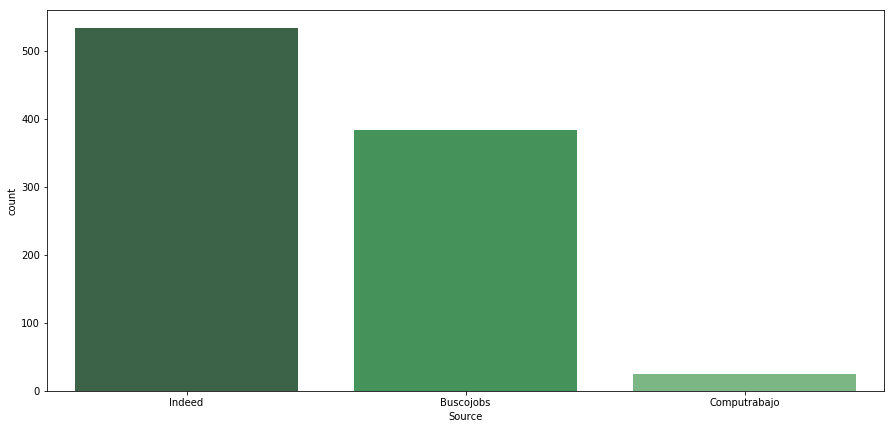

In [39]:
plt.figure(figsize=(15,7))
sns.countplot(x="Source", data=final, palette="Greens_d")

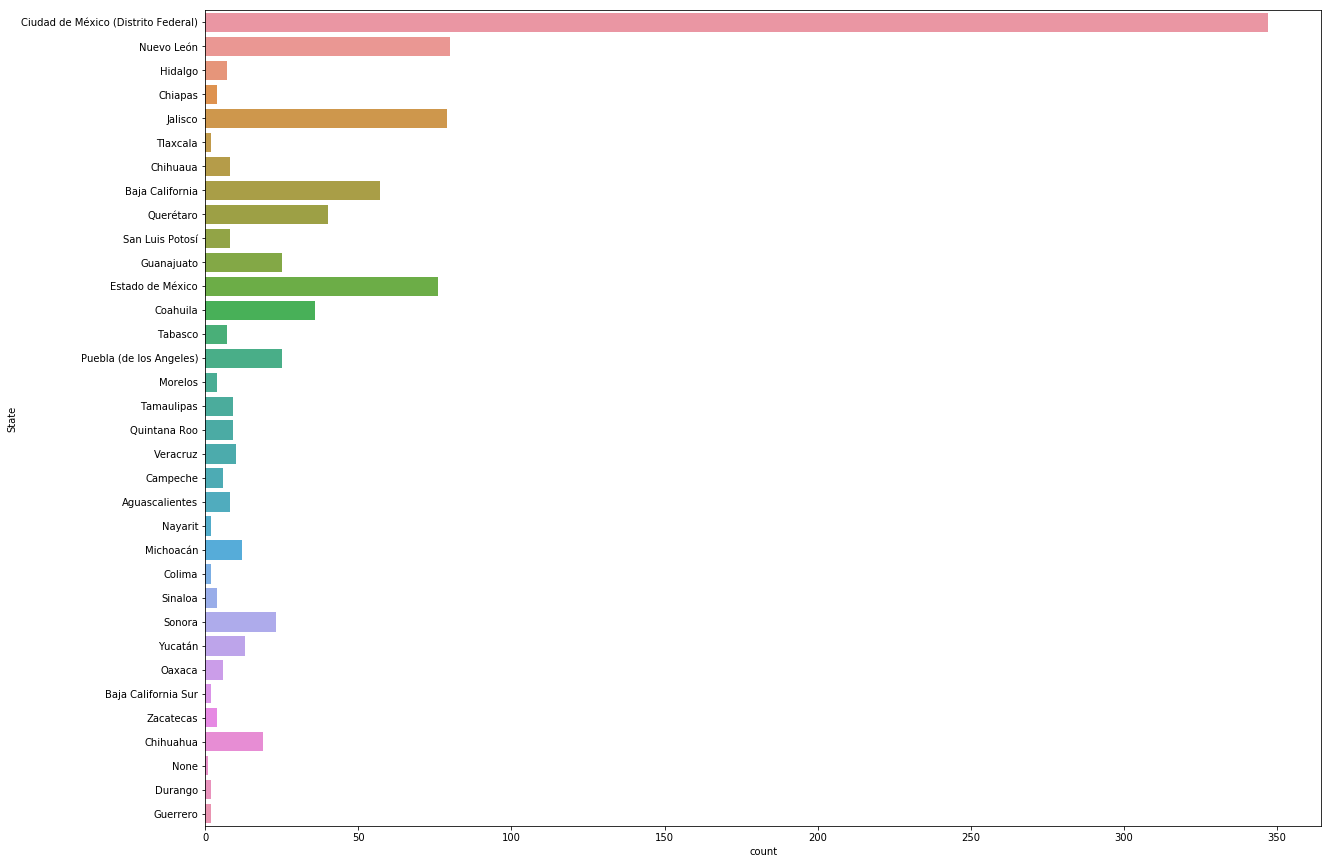

In [40]:
plt.figure(figsize=(20,15))

sns.countplot(y="State", data=final)

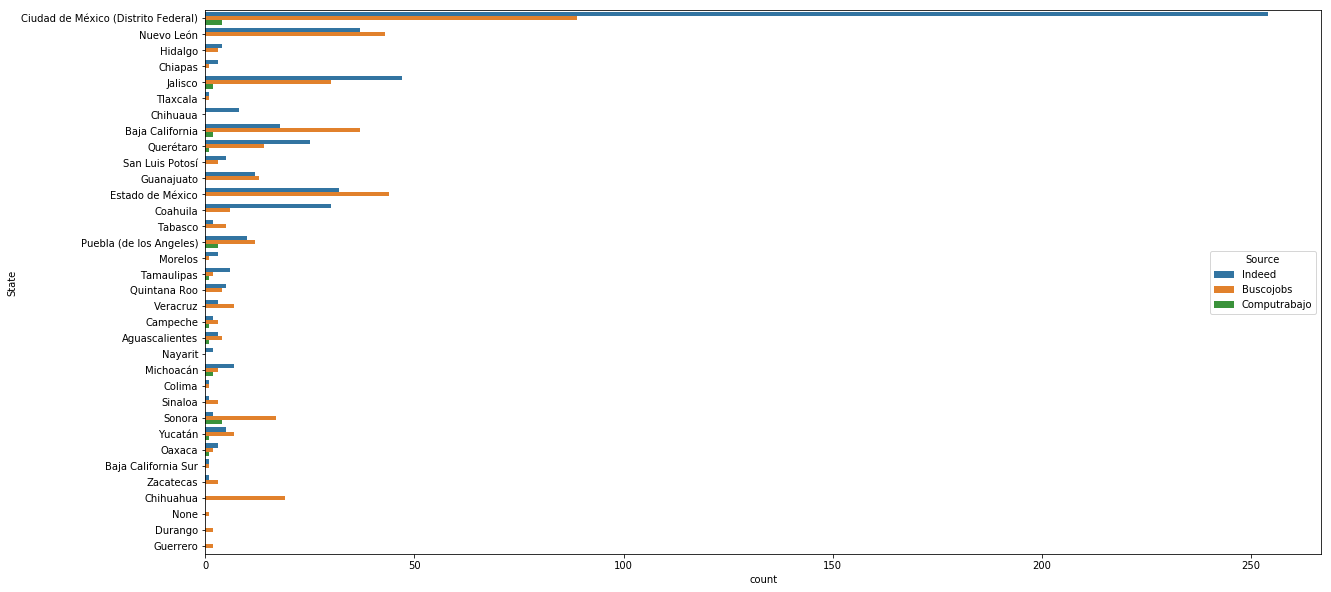

In [41]:
plt.figure(figsize=(20,10))

sns.countplot(y="State", hue="Source", data=final)

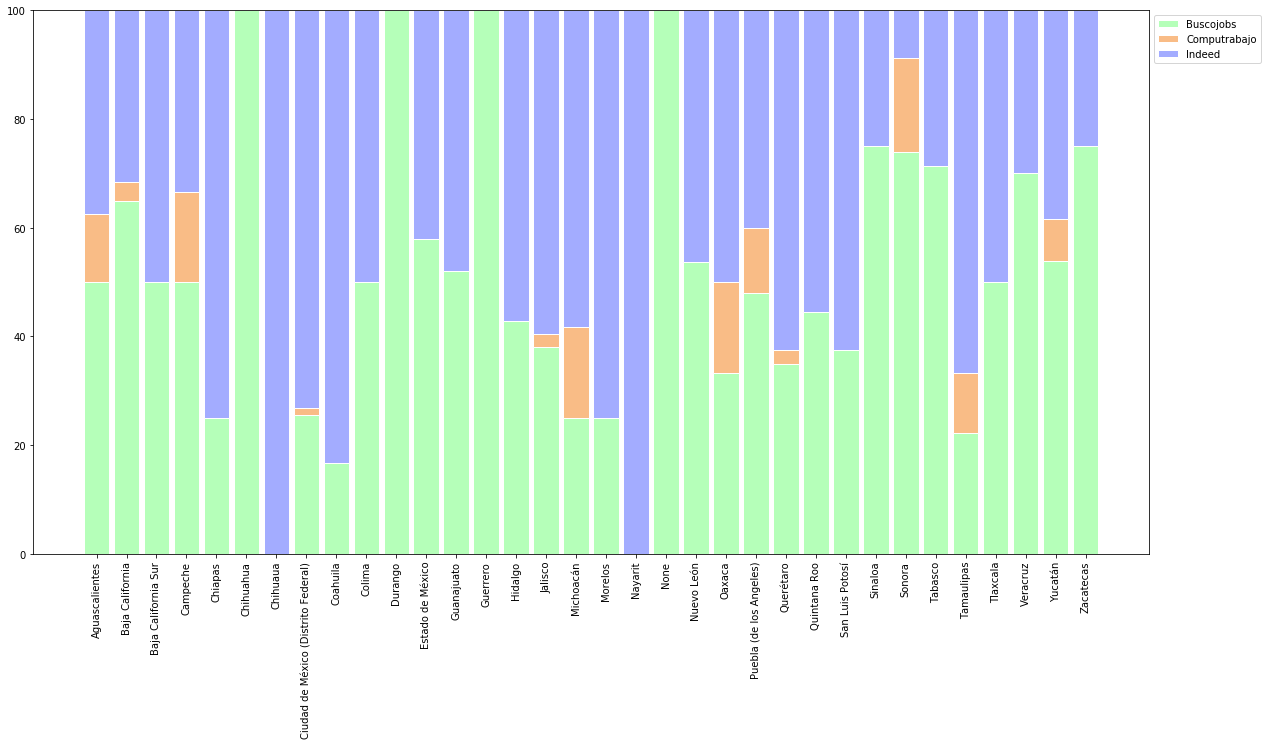

In [1144]:
# plot
barWidth = 0.85

plt.figure(figsize=(20,10))
plt.xticks(rotation='vertical')
# Create green Bars
plt.bar(final_stack_st_so['State'], Buscojobs, color='#b5ffb9', edgecolor='white', width=barWidth, label="Buscojobs")
# Create orange Bars
plt.bar(final_stack_st_so['State'], Computrabajo, bottom=Buscojobs, color='#f9bc86', edgecolor='white', width=barWidth, label="Computrabajo")
# Create blue Bars
plt.bar(final_stack_st_so['State'], Indeed, bottom=[i+j for i,j in zip(Buscojobs, Computrabajo)], color='#a3acff', edgecolor='white', width=barWidth, label="Indeed")
# Add a legend
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)


C:\Users\jparr\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


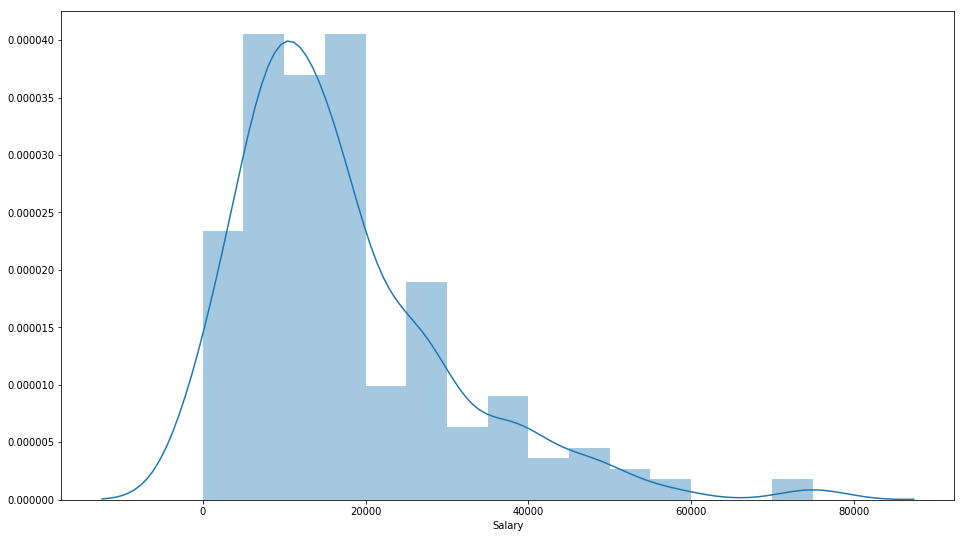

In [38]:
plt.figure(figsize=(16,9))
sns.distplot(final['Salary'].dropna())


In [1143]:
final_stack_st_so = final.groupby(['State','Source']).size()
final_stack_st_so = pd.DataFrame(final_stack_st_so)


final_stack_st_so = pd.pivot_table(final_stack_st_so, index='State', columns=['Source'])
where_are_NaNs = np.isnan(final_stack_st_so)
final_stack_st_so[where_are_NaNs] = 0

final_stack_st_so = final_stack_st_so.reset_index(level = 'State')


# From raw value to percentage
totals = [i+j+k for i,j,k in zip(final_stack_st_so[0, 'Buscojobs'], final_stack_st_so[0, 'Computrabajo'], final_stack_st_so[0, 'Indeed'])]
Buscojobs = [i / j * 100 for i,j in zip(final_stack_st_so[0, 'Buscojobs'], totals)]
Computrabajo = [i / j * 100 for i,j in zip(final_stack_st_so[0, 'Computrabajo'], totals)]
Indeed = [i / j * 100 for i,j in zip(final_stack_st_so[0, 'Indeed'], totals)]


In [34]:
plt.line(final_stack_st_so['State'], totals, color='#b5ffb9')


AttributeError: module 'matplotlib.pyplot' has no attribute 'line'

In [292]:
ts_stack_date = final.groupby(['Date']).size()
ts_stack_date = pd.DataFrame(ts_stack_date)
# ts_stack_date = pd.pivot_table(ts_stack_date, index='Date', columns=['Source'])
ts_stack_date = ts_stack_date.reset_index()
cmap = {'Date': 'Date', 0: 'Frequency'}
ts_stack_date = ts_stack_date.rename(columns=cmap)
ts_stack_date.head()


Date  Frequency
0  2020-03-12          1
1  2020-03-13          1
2  2020-03-18          2
3  2020-03-19          1
4  2020-03-20          2

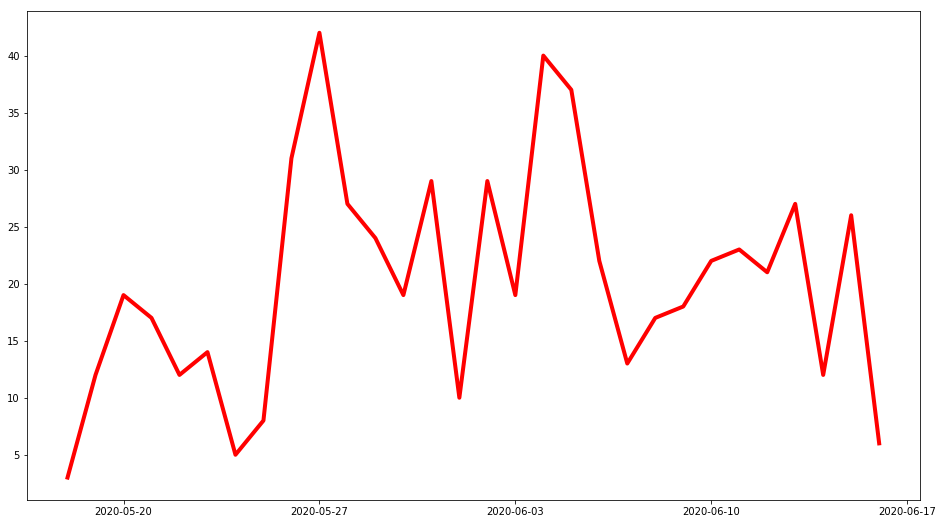

In [293]:
plt.figure(figsize=(16,9))
start_date = '2020-05-17'
cut_ts_stack_date = (ts_stack_date['Date'] > start_date)
cut_ts_stack_date = ts_stack_date.loc[cut_ts_stack_date]
cut_ts_stack_date = pd.DataFrame(cut_ts_stack_date)
cut_ts_stack_date['Date'] = pd.to_datetime(cut_ts_stack_date['Date'])
# cut_ts_stack_date.plot(x="Date", y='Frequency')
plt.plot( 'Date', 'Frequency', data=cut_ts_stack_date, marker='', markerfacecolor='red', markersize=12, color='red', linewidth=4)

# cut_ts_stack_date.xaxis.set_major_formatter(cut_ts_stack_date.DateFormatter('%Y/%M/%D'))

In [281]:
ts_stack_date = final.groupby(['Date', 'Source']).size().unstack().reset_index()
ts_stack_date = pd.DataFrame(ts_stack_date)
# ts_stack_date = pd.pivot_table(ts_stack_date, index='Date', columns=['Source'])
# ts_stack_date = ts_stack_date.reset_index(level= ['Date', 'Source'])


In [287]:
start_date = '2020-05-17'
cut_ts_stack_date = (ts_stack_date['Date'] > start_date)
ts_stack_date = ts_stack_date.loc[cut_ts_stack_date]
ts_stack_date = pd.DataFrame(ts_stack_date)
ts_stack_date['Date'] = pd.to_datetime(ts_stack_date['Date'])
# cut_ts_stack_date.plot(x="Date", y='Frequency')
# plt.plot( 'Date', 'Indeed', data=cut_ts_stack_date, marker='', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
ts_stack_date = ts_stack_date.fillna(0)


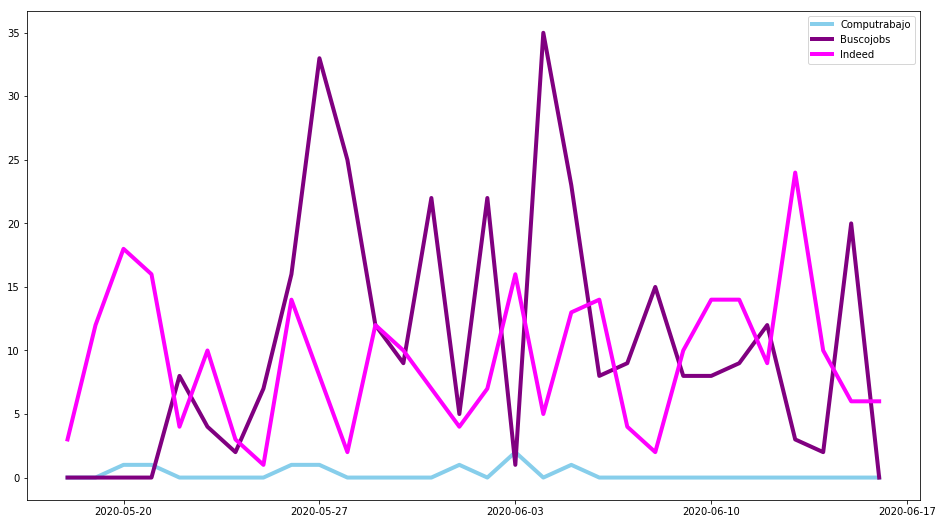

In [288]:
# multiple line plot
plt.figure(figsize=(16,9))
plt.plot( 'Date', 'Computrabajo', data=ts_stack_date, marker='', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot( 'Date', 'Buscojobs', data=ts_stack_date, marker='', color='purple', linewidth=4)
plt.plot( 'Date', 'Indeed', data=ts_stack_date, marker='', color='magenta', linewidth=4)
plt.legend()
